In [1]:
import os

###################################################################################
# Check that these are the correct paths running (change if necessary)

# Finn's Laptop
studydir = '/mnt/e/KPUM_NODDI/Data'
codedir = os.path.join('/home/finn/Code/KPUM_NODDI_ssd','kpum_noddi')
codedir = os.path.join('/home/finn/Code/','kpum_noddi')

# KPUM Workstation
studydir = '/mnt/e/Finn/KPUM_NODDI/Data'
codedir = os.path.join('/home/radio/KPUM_NODDI','code/kpum_noddi')

###################################################################################
# USER INPUT - START

# Study details
derivatives = 'derivatives/dMRI_op' # e.g. derivatives/dMRI_np' or 'derivatives/dMRI_op'
protocol = 'ORIG' # 'NEW' or 'ORIG'
clinicaldata = 'NODDI_Clinical_Information_FL_suggestion_20250326.xlsx' # Up-to-date file with clinical data

# USER INPUT - END
##################################################################################

# tsv-files to keep track of in studydir/niftibasefolder
subjecttrackerfile = 'Subject_Tracker_for_dmri_dtidkinoddi_pipeline.tsv'


Read the clinical data

In [2]:
import pandas as pd
import numpy as np
import os
import glob

# Define I/O folders and files
clinicaldatafolder = 'clinicaldata'
clinicaldatafile = os.path.join(studydir, clinicaldatafolder, clinicaldata)

def perform_process(processcall) :
    import os, subprocess
    # Perform the process given by the processcall by launching into terminal
    p=subprocess.Popen(processcall, stdout=subprocess.PIPE, shell=True)
    # Poll process.stdout to show stdout live
    while True:
        output = p.stdout.readline()
        if p.poll() is not None:
            break
        if output:
            print(output.strip().decode("utf-8"))
    rc = p.poll()


########################################
## START

currdir = os.getcwd()
os.chdir(studydir)

# Read the Clinicaldata-file.xlsx
df_clinical = pd.read_excel(clinicaldatafile, dtype=str, sheet_name='Patient Data') # Read as string to preserve empty cells
# Replace empty strings and whitespace-only strings with NaN
df_clinical = df_clinical.applymap(lambda x: np.nan if pd.isna(x) or str(x).strip() == "" else x)
# Remove columns where all values are NaN
df_clinical = df_clinical.dropna(axis=1, how='all')
# Drop rows where all columns except 'Study ID' are NaN
df_clinical = df_clinical.dropna(subset=df_clinical.columns[1:], how='all')
# Reset index if needed
df_clinical = df_clinical.reset_index(drop=True)


# Print full dataframe without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("\nFull dataframe after removing all-NaN columns:")
#print(df_clinical)

# Display basic information about the patient dataset
print("Patient Data Summary:")
print("-" * 50)
print(f"Number of patients: {len(df_clinical)}")
print("\nFirst few rows of patient data:")
display(df_clinical.head())
print("\nColumns in patient data:")
print(df_clinical.columns.tolist())


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/Finn/KPUM_NODDI/Data'

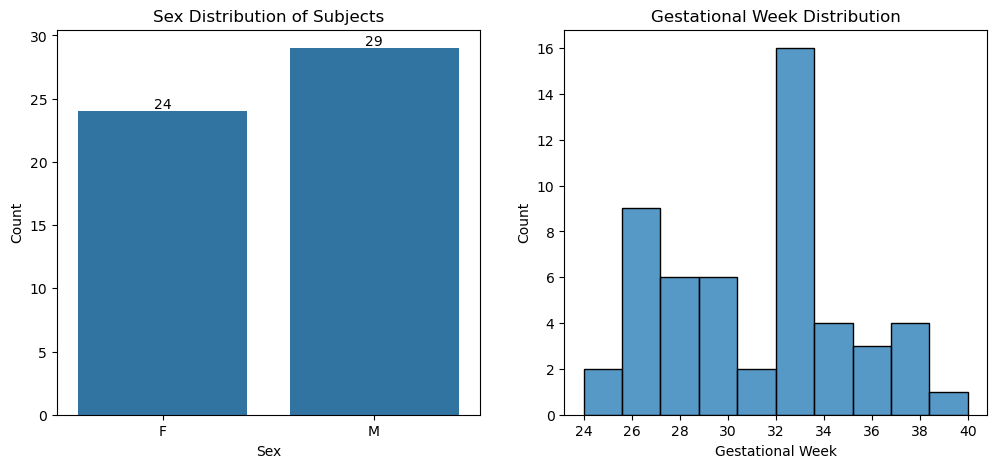

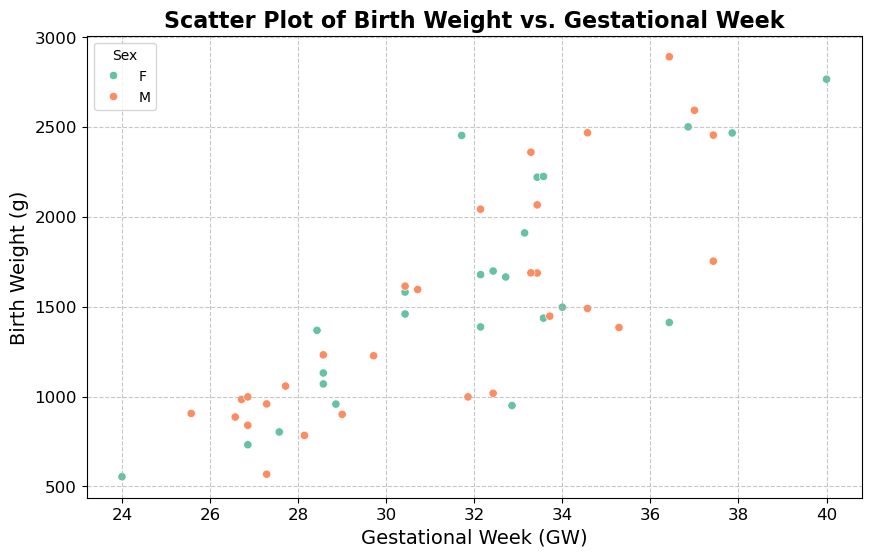


Demographic Summary for Subjects:
--------------------------------------------------
Total subjects: 53

Sex Distribution:
Sex
M    29
F    24
Name: count, dtype: int64

Gestational Week Statistics:
count    53.000000
mean     31.590296
std       3.682454
min      24.000000
25%      28.571429
50%      32.142857
75%      33.571429
max      40.000000
Name: Combined_GA, dtype: float64

Birth Weigh Statistics:
count      53.000000
mean     1524.584906
std       615.373165
min       554.000000
25%       998.000000
50%      1447.000000
75%      1910.000000
max      2890.000000
Name: Birth_Weight, dtype: float64


In [ ]:
#
# PRINT SOME DEMOGRAPHIC DATA
# 

import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with demographic info for subjects with connectome data
df_clinical_demo = pd.DataFrame({
    'Subject ID': df_clinical['Study ID'],
    'Sex': df_clinical['Sex'],
    'GAatBirth_Week': df_clinical['GAatBirth Week'],
    'GAatBirth_Day': df_clinical['GAatBirth Day'],
    'Birth_Weight': df_clinical['BodyWeight (g)'],
    'PMA': df_clinical['MR1 PMA at Scan(d)'],
    })

df_clinical_demo['GAatBirth_Week'] = pd.to_numeric(df_clinical_demo['GAatBirth_Week'], errors='coerce') # Ensure GAatBirth_Week
df_clinical_demo['GAatBirth_Day'] = pd.to_numeric(df_clinical_demo['GAatBirth_Day'], errors='coerce') # Ensure GAatBirth_Week
df_clinical_demo['Birth_Weight'] = pd.to_numeric(df_clinical_demo['Birth_Weight'], errors='coerce') # Ensure Birth_Weight is numeric
df_clinical_demo['PMA'] = pd.to_numeric(df_clinical_demo['PMA'], errors='coerce') # Ensure PMA is numeric

# Add a new column for the combined gestational age
df_clinical_demo['Combined_GA'] = df_clinical_demo['GAatBirth_Week'] + (df_clinical_demo['GAatBirth_Day']/7) # Convert to days)
# Add the new variable diff_PMA_GA to df_clinical_demo
df_clinical_demo['diff_PMA_GA'] = df_clinical_demo['PMA'] - df_clinical_demo['Combined_GA']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot sex distribution
df_clinical_demo_sorted = df_clinical_demo.sort_values(by='GAatBirth_Week', ascending=True)

sns.countplot(data=df_clinical_demo_sorted, x='Sex', ax=ax1)
ax1.set_title('Sex Distribution of Subjects')
ax1.set_xlabel('Sex')
ax1.set_ylabel('Count')

# Add count labels on top of bars
for i in ax1.containers:
    ax1.bar_label(i)

# Plot GAatBirth_Week distribution
sns.histplot(data=df_clinical_demo_sorted, x='GAatBirth_Week', bins=10, ax=ax2)
ax2.set_title('Gestational Week Distribution')
ax2.set_xlabel('Gestational Week')
ax2.set_ylabel('Count')

# Sort the data by GAatBirth_Week and Birth Weight for better visualization
df_clinical_demo_sorted = df_clinical_demo.sort_values(by=['GAatBirth_Week', 'Birth_Weight'], ascending=[True, True])

# Create a scatter plot of Birth Weight against Gestational Week
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Combined_GA", y="Birth_Weight", data=df_clinical_demo_sorted, hue="Sex", palette="Set2")

# Add a title and axis labels
plt.title("Scatter Plot of Birth Weight vs. Gestational Week", fontsize=16, fontweight='bold')
plt.xlabel("Gestational Week (GW)", fontsize=14)
plt.ylabel("Birth Weight (g)", fontsize=14)

# Customize tick parameters for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

# Print summary statistics
print("\nDemographic Summary for Subjects:")
print("-" * 50)
print(f"Total subjects: {len(df_clinical_demo_sorted)}")
print("\nSex Distribution:")
print(df_clinical_demo_sorted['Sex'].value_counts())
print("\nGestational Week Statistics:")
print(df_clinical_demo_sorted['Combined_GA'].describe())
print("\nBirth Weigh Statistics:")
print(df_clinical_demo_sorted['Birth_Weight'].describe())


In [ ]:
import pandas as pd

# Now we are going to import the JHU-MNI LUT

codedir = '/home/finn/Code/kpum_noddi'
lutfile = os.path.join(codedir, 'label_names','OpenMAP-Di','neonate_multilevel_lookup_table_170labels_v2.csv')
df_lut = pd.read_csv(lutfile)
# Remove empty columns
df_lut = df_lut.dropna(axis=1, how='all')
# Remove empty rows
df_lut = df_lut.dropna(how='all')
print(df_lut)


     Label                                  Level 5   
0        1                                    SPG_L  \
1        2                              Cingulate_L   
2        3                                    SFG_L   
3        4                                    MFG_L   
4        5                                    IFG_L   
5        6                                   PrCG_L   
6        7                                   PoCG_L   
7        8                                     AG_L   
8        9                                   PrCu_L   
9       10                                     Cu_L   
10      11                                     LG_L   
11      12                                    FuG_L   
12      13                                    PHG_L   
13      14                                    SOG_L   
14      15                                    IOG_L   
15      16                                    MOG_L   
16      17                                    ENT_L   
17      18

Now read the ROI data

In [ ]:
# DTI
# 

import glob
import json
import pandas as pd

# Change to the directory containing the JSON files
os.chdir(os.path.join(studydir, derivatives))

# Define the path pattern to list JSON files
json_files = glob.glob("sub-0*/ses-MR1/dwi/dti/*stats.json")

# Initialize a list to store the extracted data
data = []

# Loop through each JSON file
for json_file in json_files:
    # Extract the subject ID from the file path
    subject = json_file.split('/')[0].split('-')[1].lstrip('0')  # Extracts "XXX" and removes leading zeros

    # Read the JSON file
    with open(json_file, 'r') as f:
        json_data = json.load(f)

    # Extract all regions and their data
    for entry in json_data['data']:
        data.append({
            'Subject ID': subject,
            'Label': entry['Label'],
            'Region': entry['Region'],
            'FA_mean': entry['FA_mean'],
            'FA_std': entry['FA_std'],
            'MD_mean': entry['MD_mean'],
            'MD_std': entry['MD_std'],
            'AD_mean': entry['AD_mean'],
            'AD_std': entry['AD_std'],
            'RD_mean': entry['RD_mean'],
            'RD_std': entry['RD_std']
        })

# Convert the extracted data to a DataFrame
df_roi = pd.DataFrame(data)

# Print the DataFrame
print(df_roi)



     Subject ID  Label                                   Region   FA_mean   
0             2      1                                    SPG_L  0.125013  \
1             2      2                              Cingulate_L  0.112620   
2             2      3                                    SFG_L  0.128323   
3             2      4                                    MFG_L  0.117614   
4             2      5                                    IFG_L  0.118008   
5             2      6                                   PrCG_L  0.133285   
6             2      7                                   PoCG_L  0.110215   
7             2      8                                     AG_L  0.104920   
8             2      9                                   PrCu_L  0.094648   
9             2     10                                     Cu_L  0.089173   
10            2     11                                     LG_L  0.090172   
11            2     12                                    FuG_L  0.104419   

Make some plotting

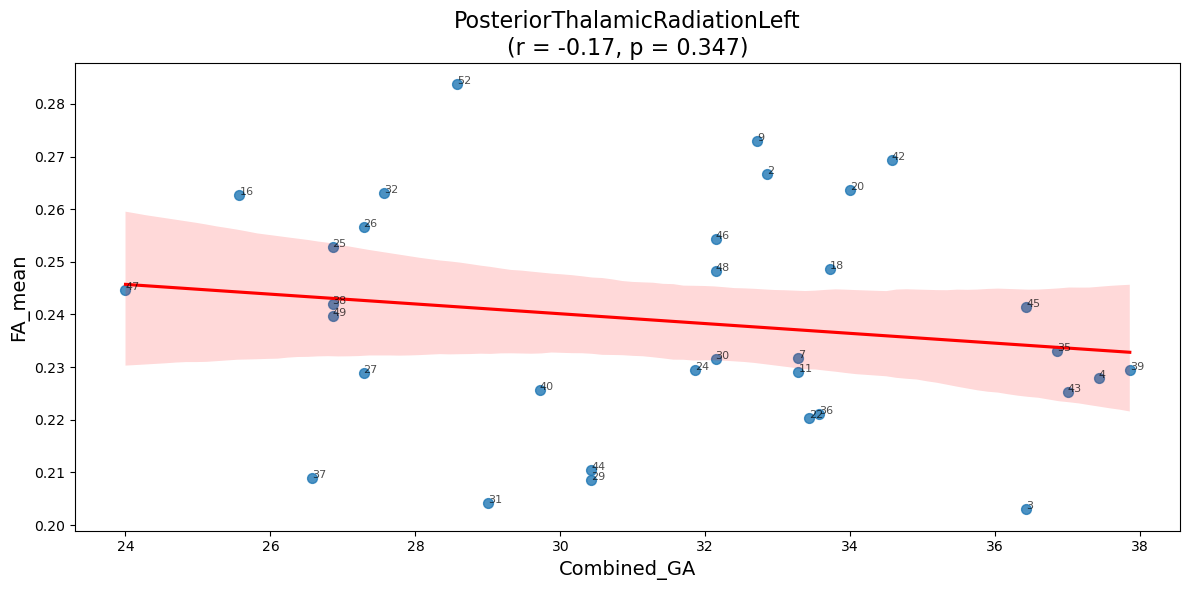

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define the ROI (Region of Interest) to plot
#roi = "ITG_R"  # Replace with your desired region
roi = "PosteriorThalamicRadiationLeft"  # Replace with your desired region 
#roi = "AnteriorLimbInternalCapsuleLeft"  # Replace with your desired region
variable_to_plot_x = "Combined_GA"  # Replace with the desired variable to plot
variable_to_plot_y = "FA_mean"  # Replace with the desired variable to plot

# Filter the DataFrame for the selected ROI
roi_data = df_roi[df_roi['Region'] == roi]

# Assuming `df_clinical_demo` contains 'Subject ID' and 'Birth_Weight', merge it with `roi_data`
roi_data = roi_data.merge(df_clinical_demo[['Subject ID', variable_to_plot_x]], on='Subject ID', how='inner')

# Calculate the Pearson correlation coefficient and p-value
r, p = pearsonr(roi_data[variable_to_plot_x], roi_data[variable_to_plot_y])
# Format the p-value for display
p_display = f"{p:.3f}" if p >= 0.001 else "< 0.001"

# Plot the scatter plot with a regression line
plt.figure(figsize=(12, 6))
sns.regplot(data=roi_data, x=variable_to_plot_x, y=variable_to_plot_y, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Annotate each point with the Subject ID
for i in range(len(roi_data)):
    plt.text(
        roi_data[variable_to_plot_x].iloc[i],
        roi_data[variable_to_plot_y].iloc[i],
        str(roi_data['Subject ID'].iloc[i]),
        fontsize=8,
        alpha=0.7
    )

# Customize the plot
plt.title(f'{roi}\n(r = {r:.2f}, p = {p_display})', fontsize=16)
plt.xlabel(variable_to_plot_x, fontsize=14)
plt.ylabel(variable_to_plot_y, fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

Now plot all the ROIs

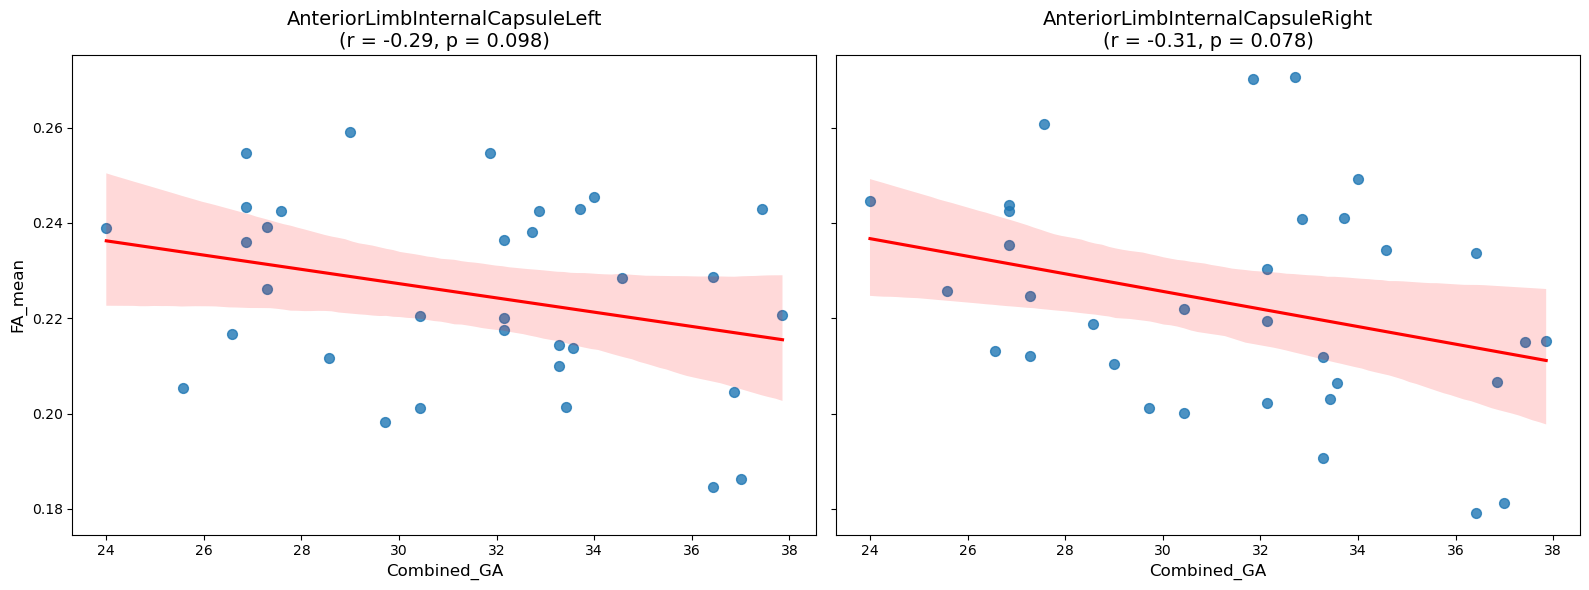

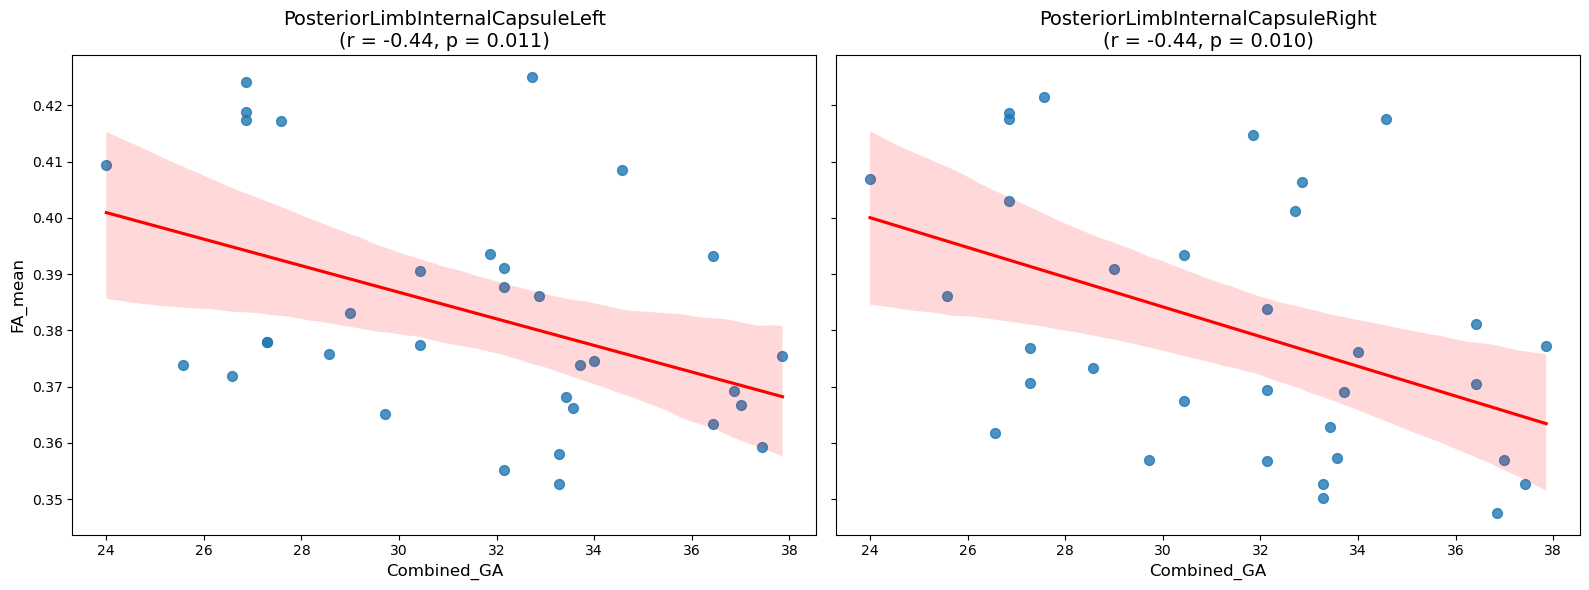

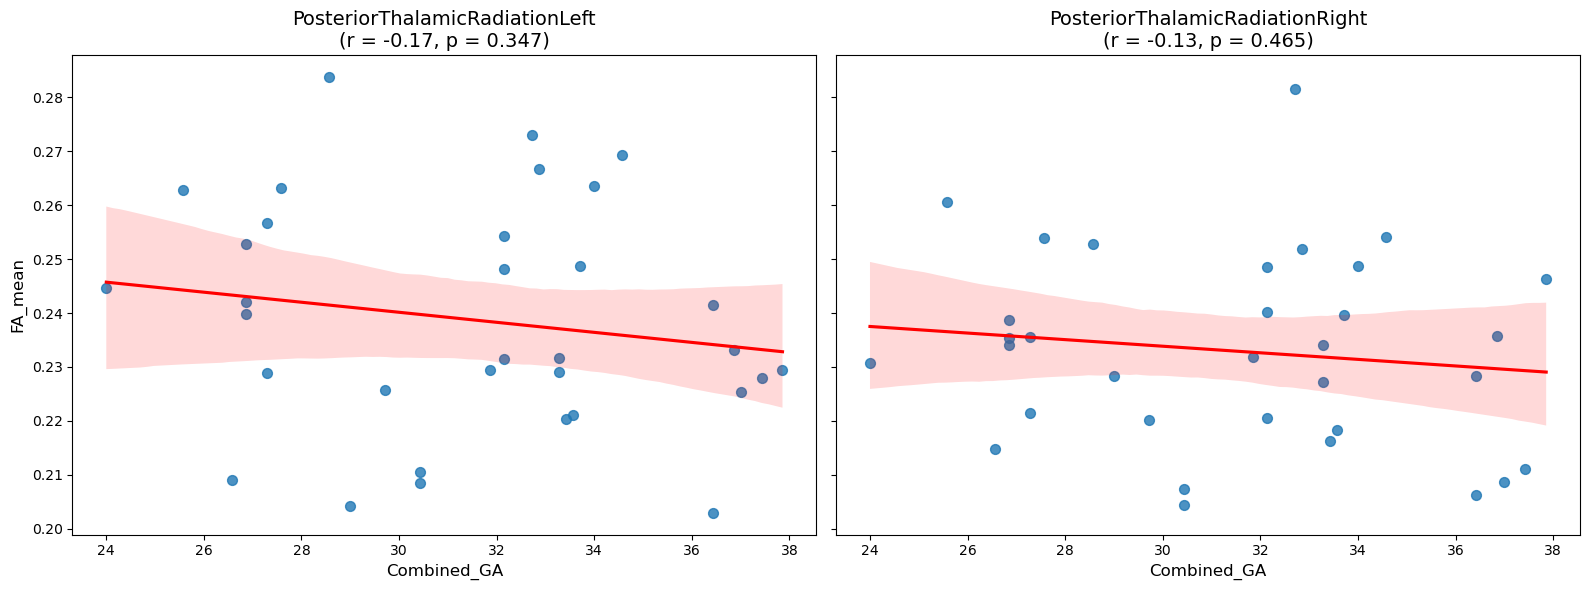

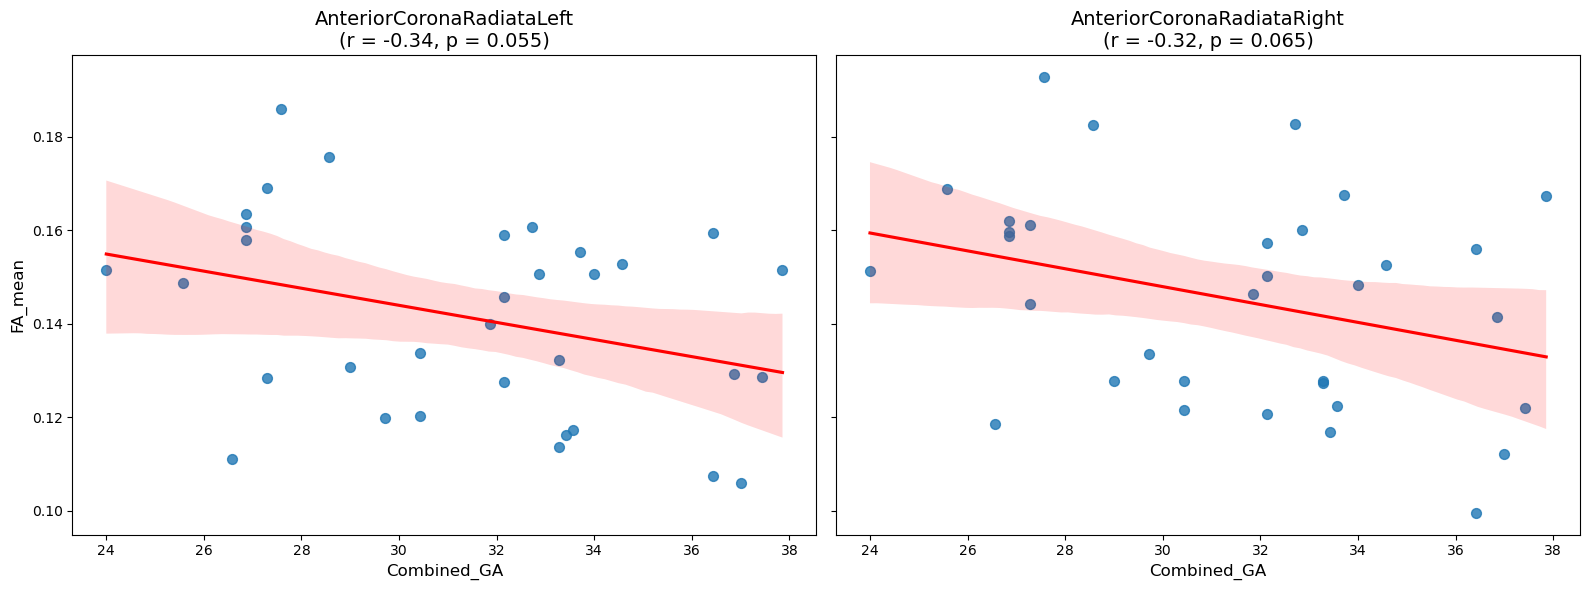

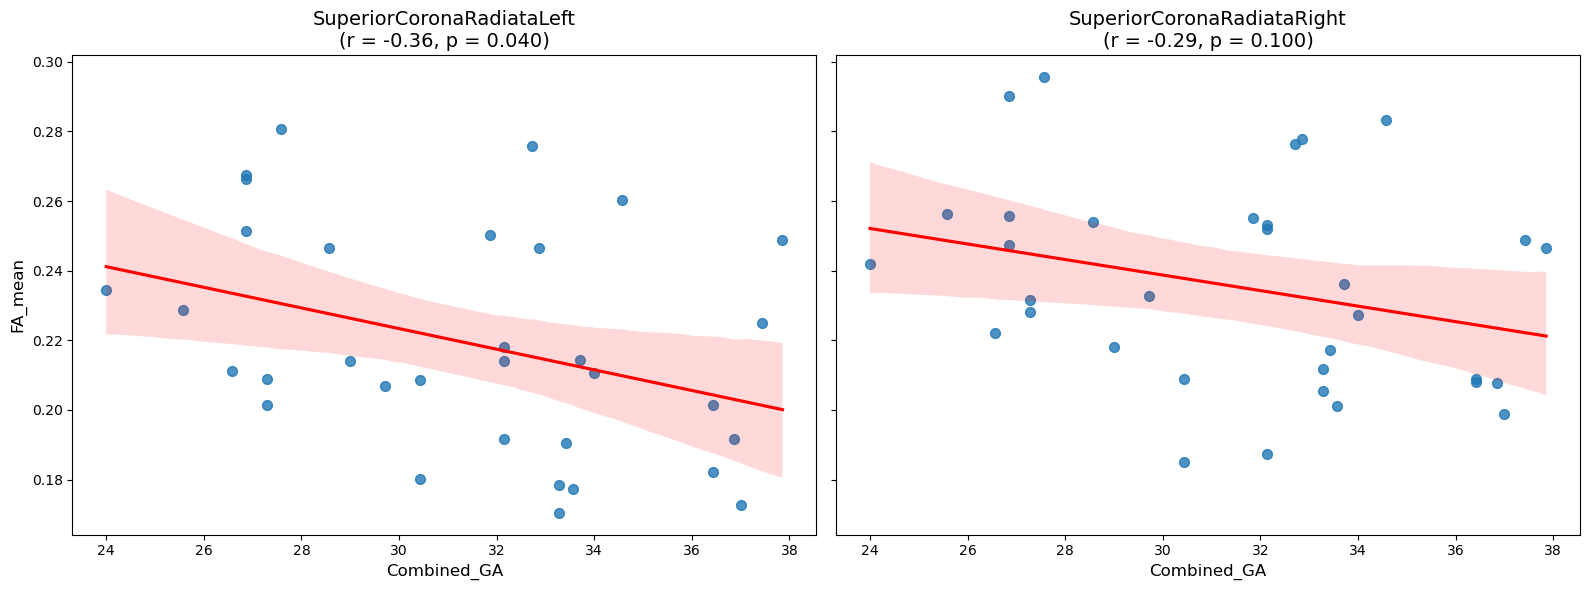

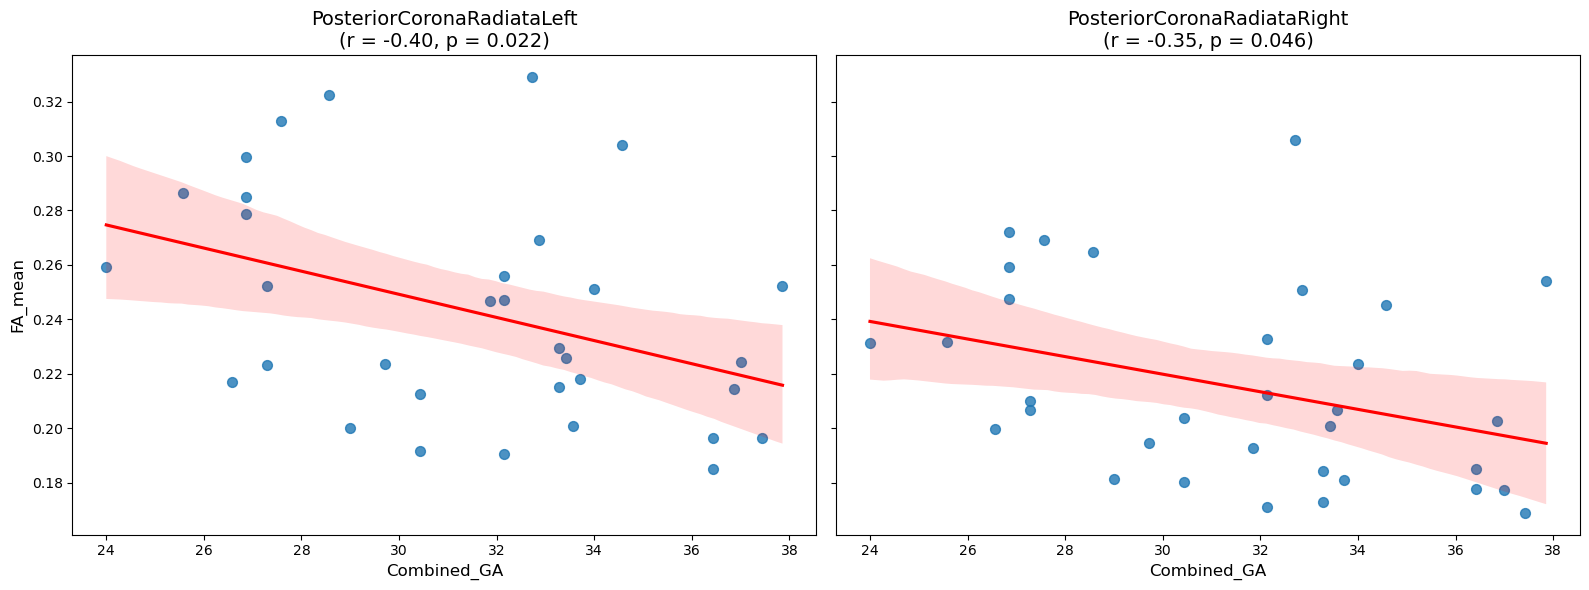

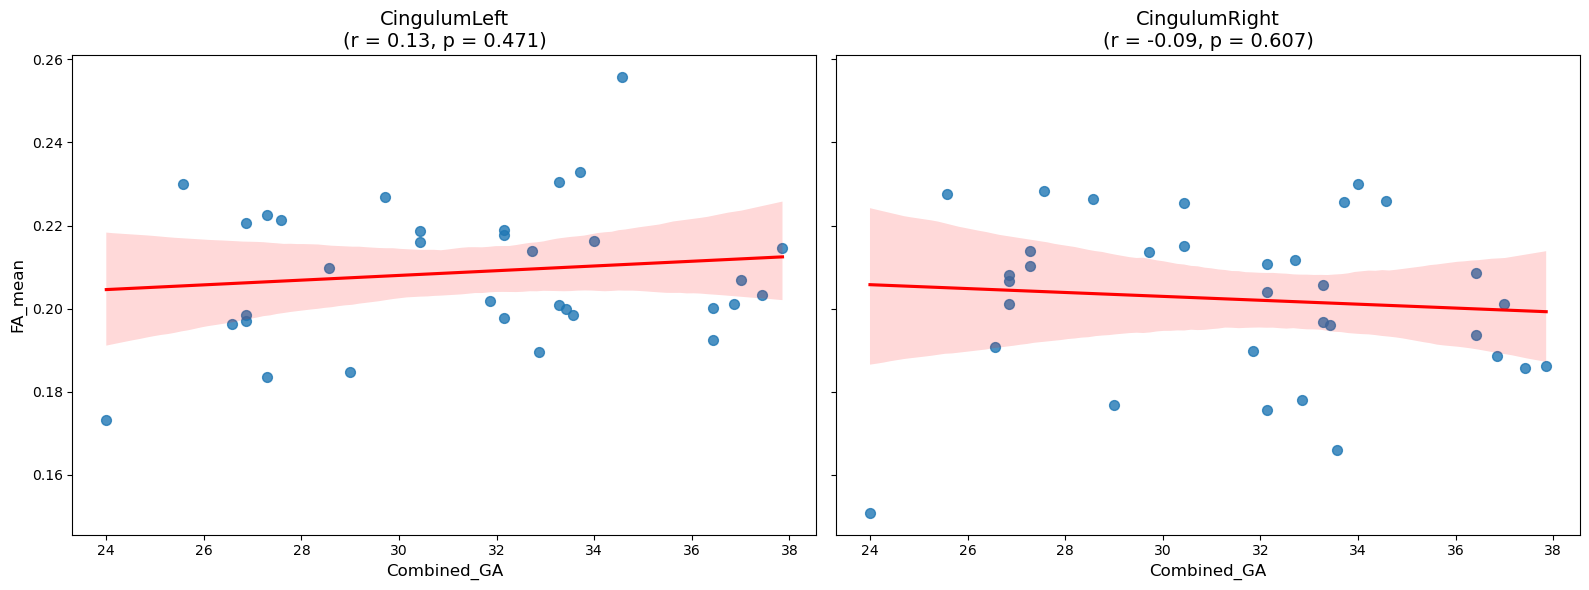

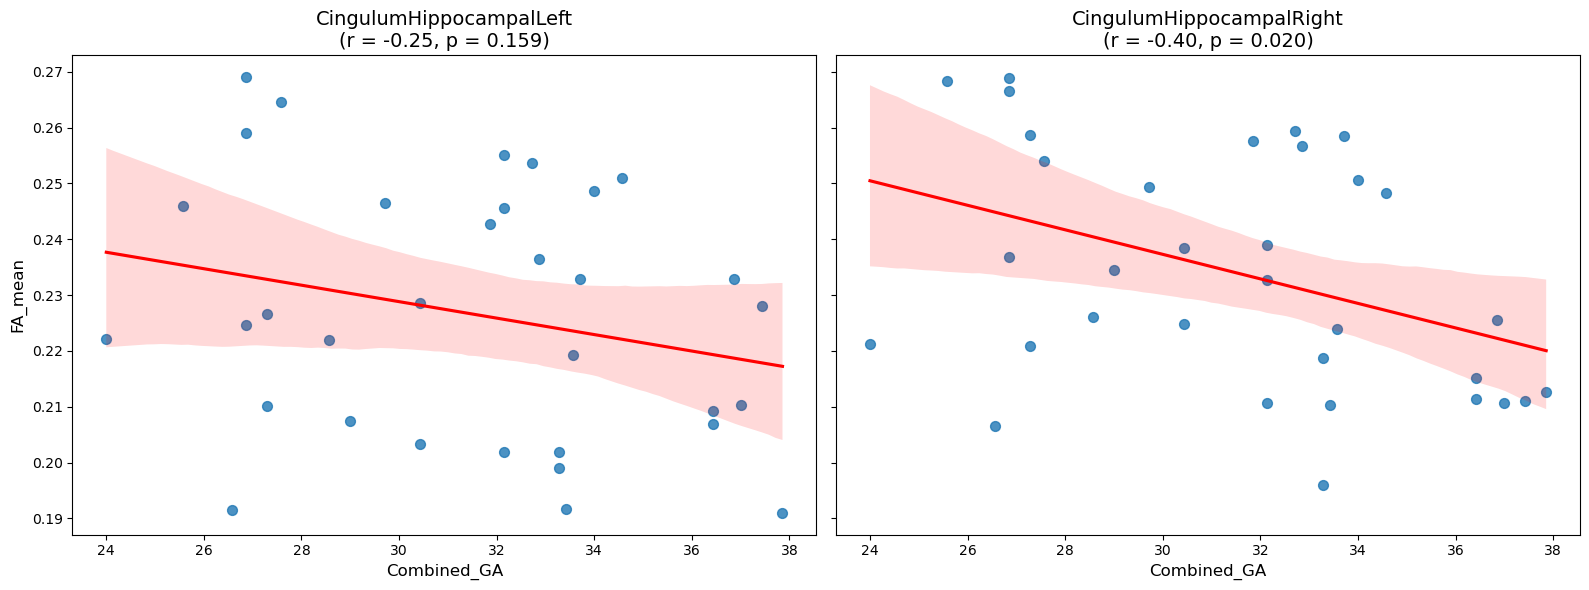

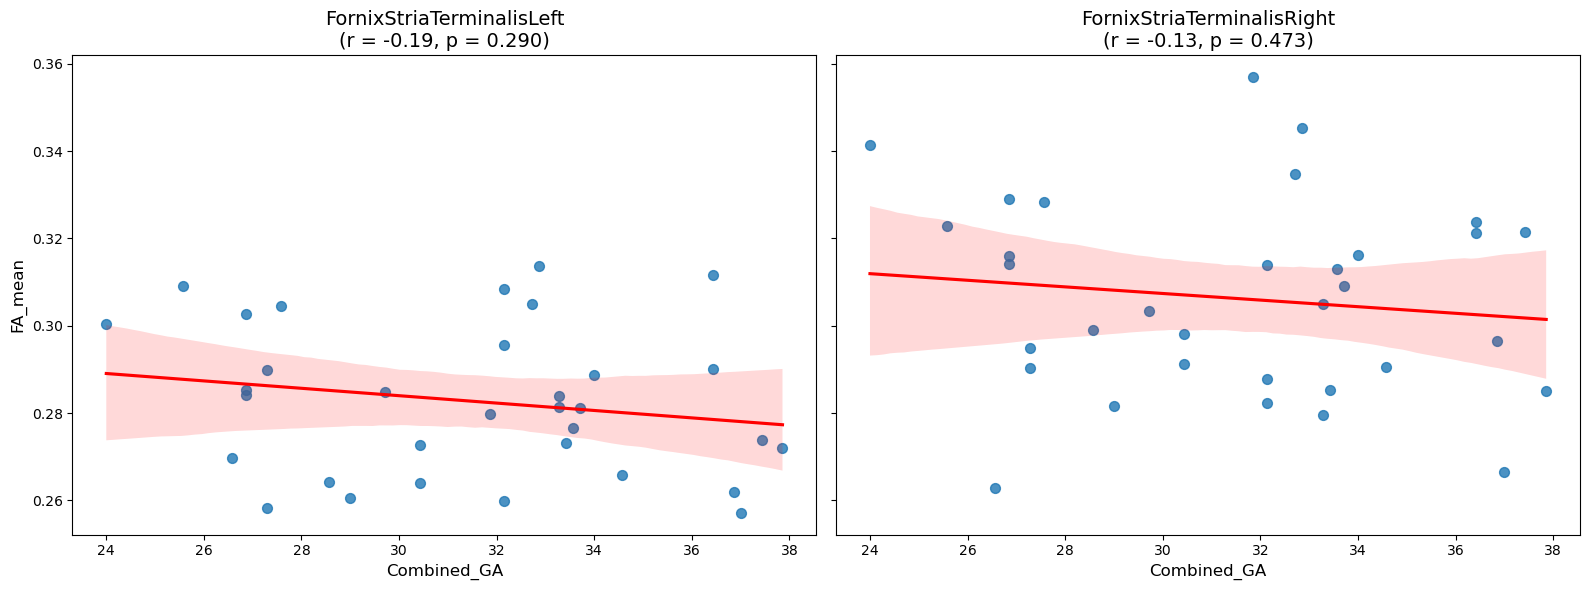

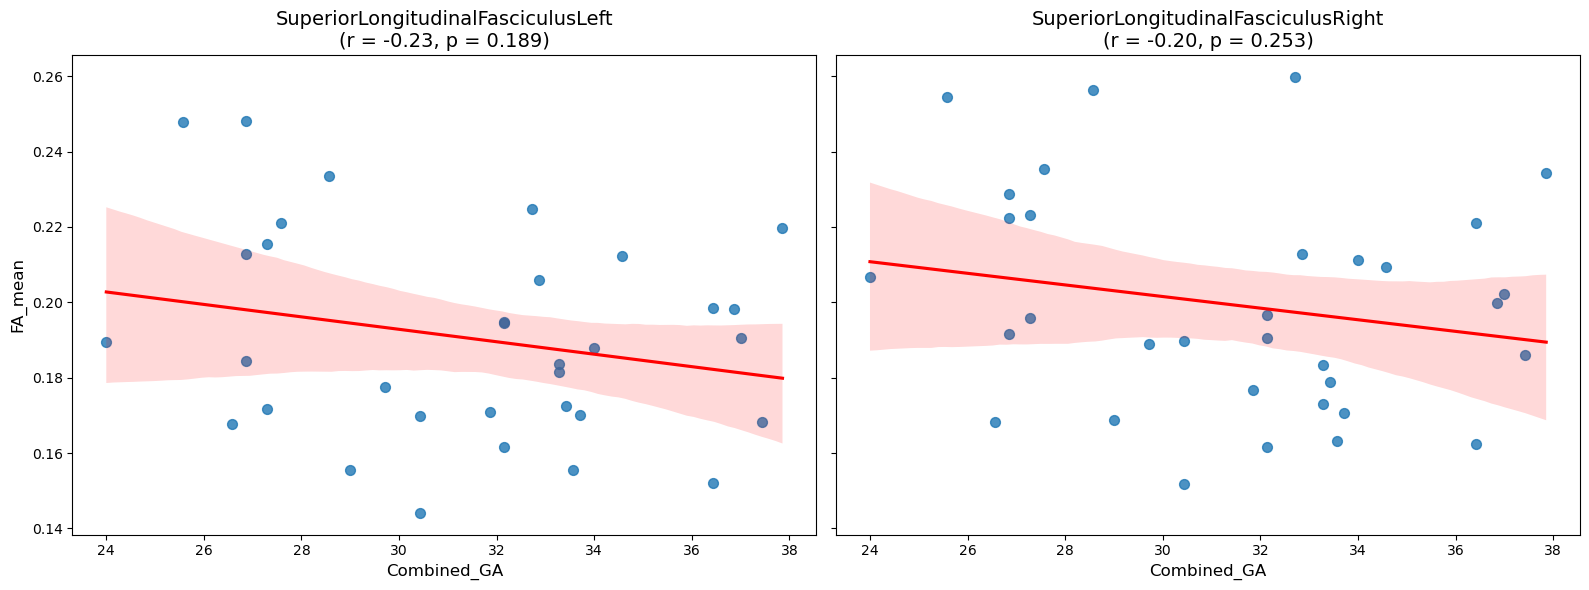

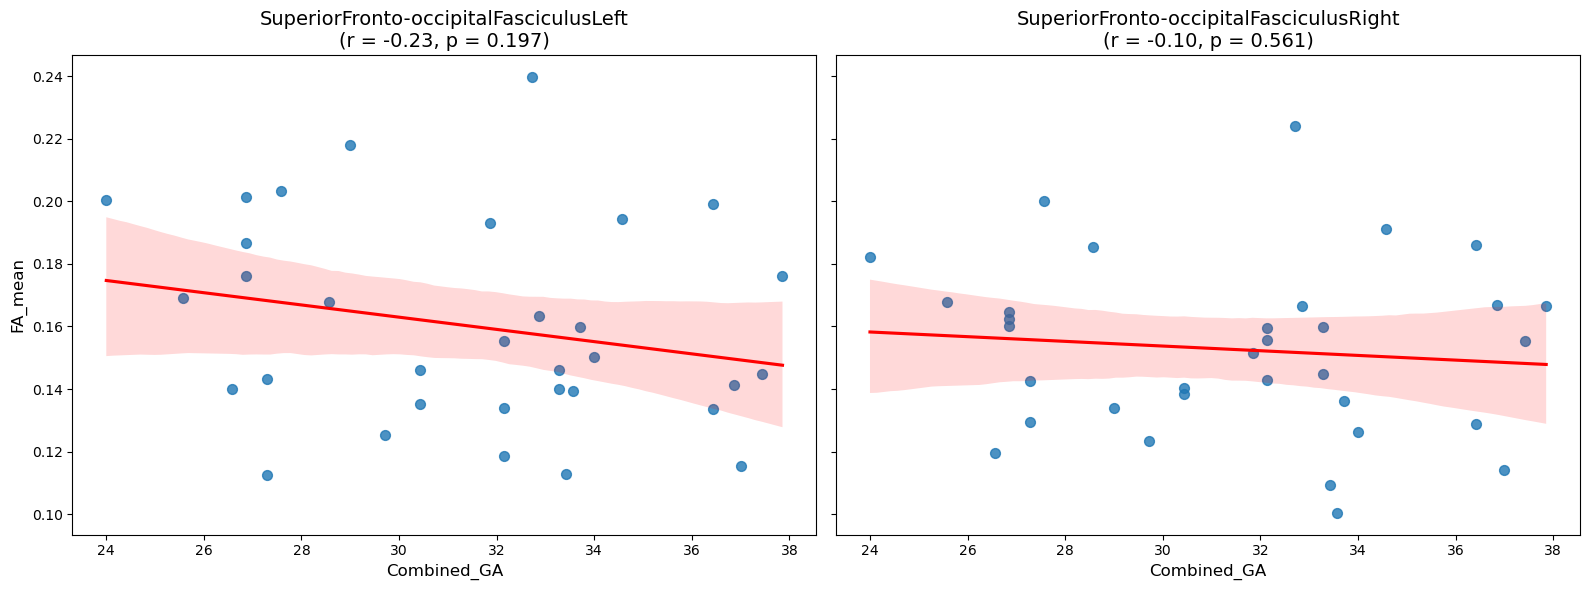

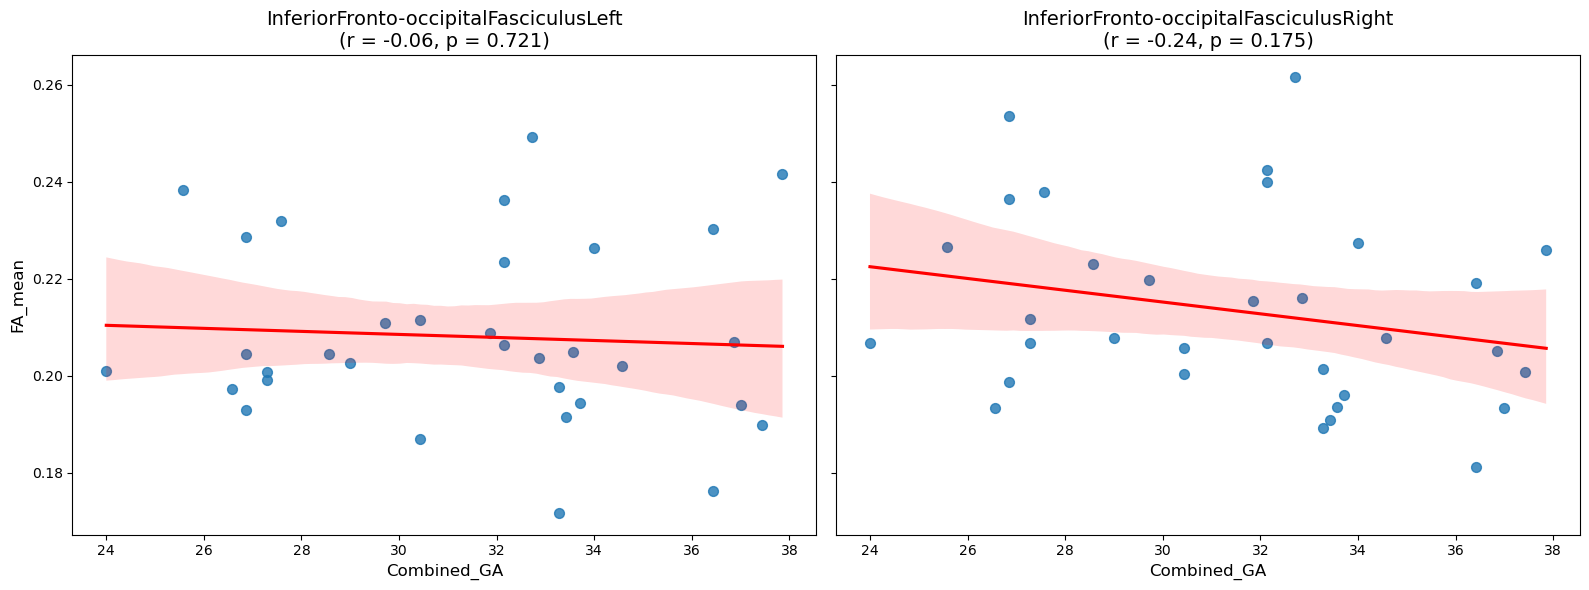

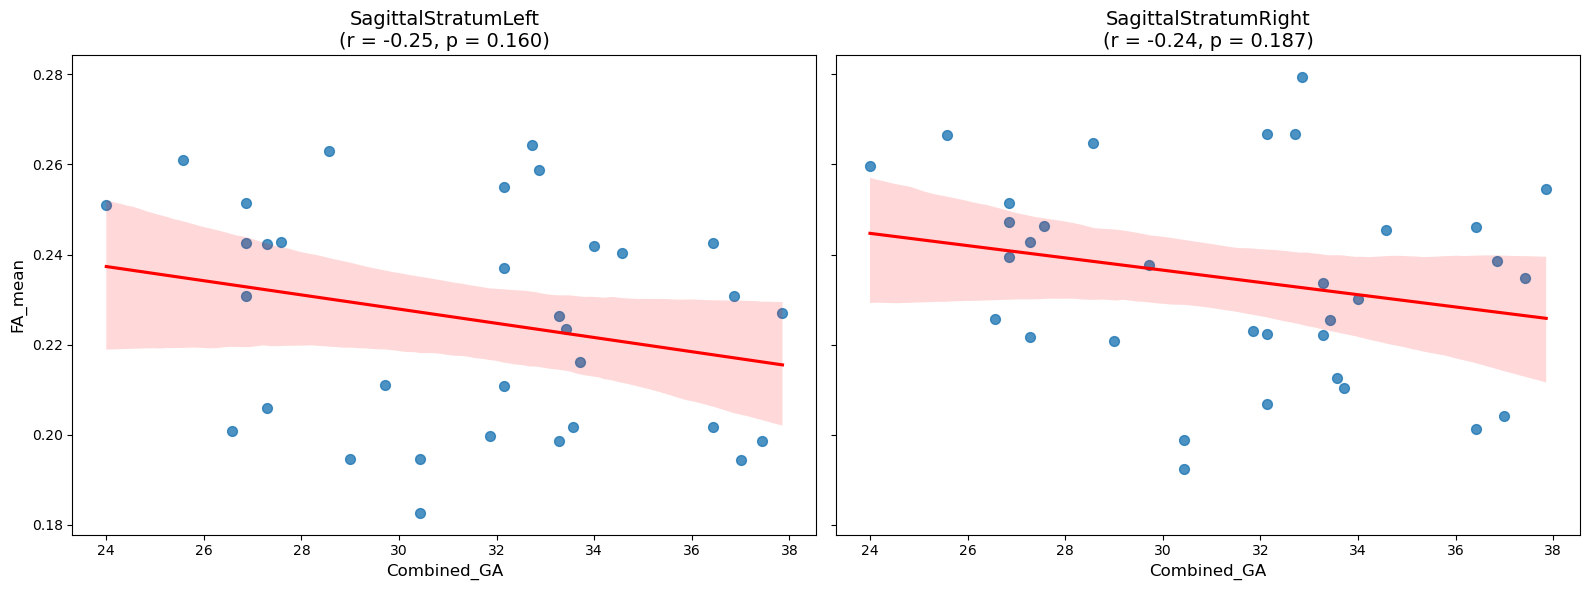

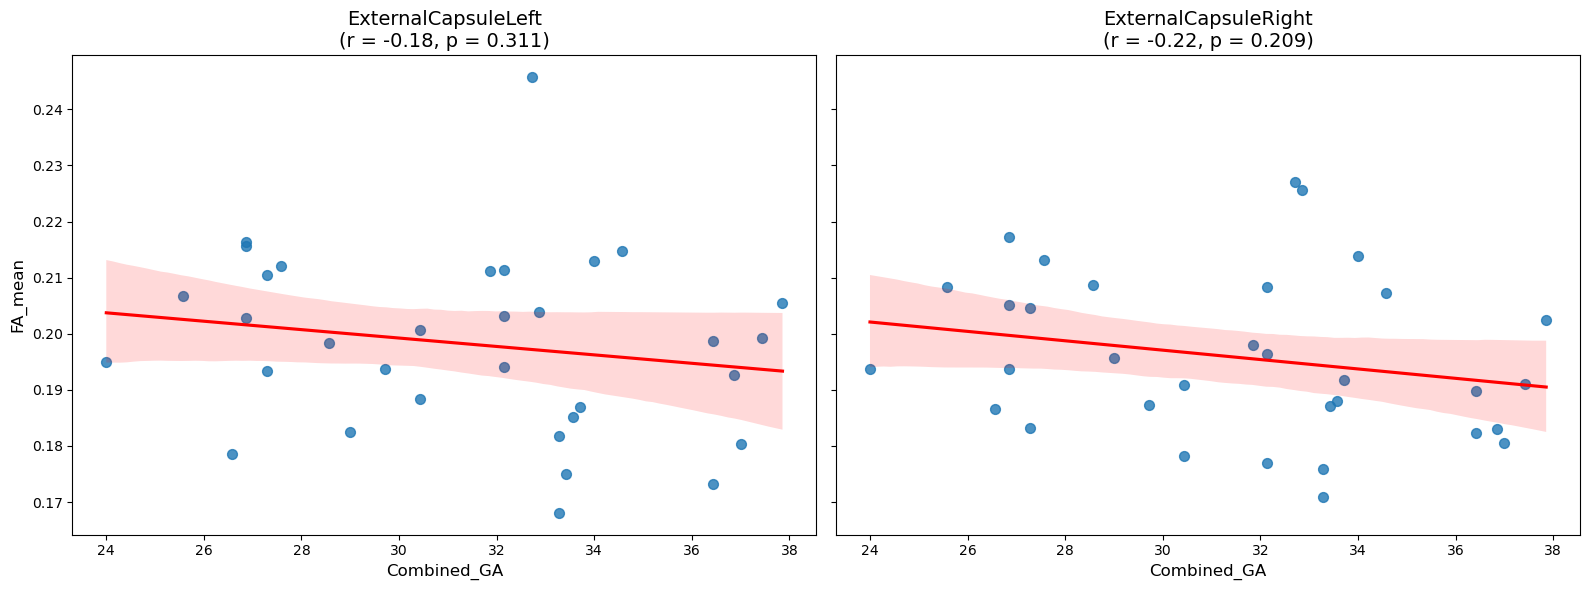

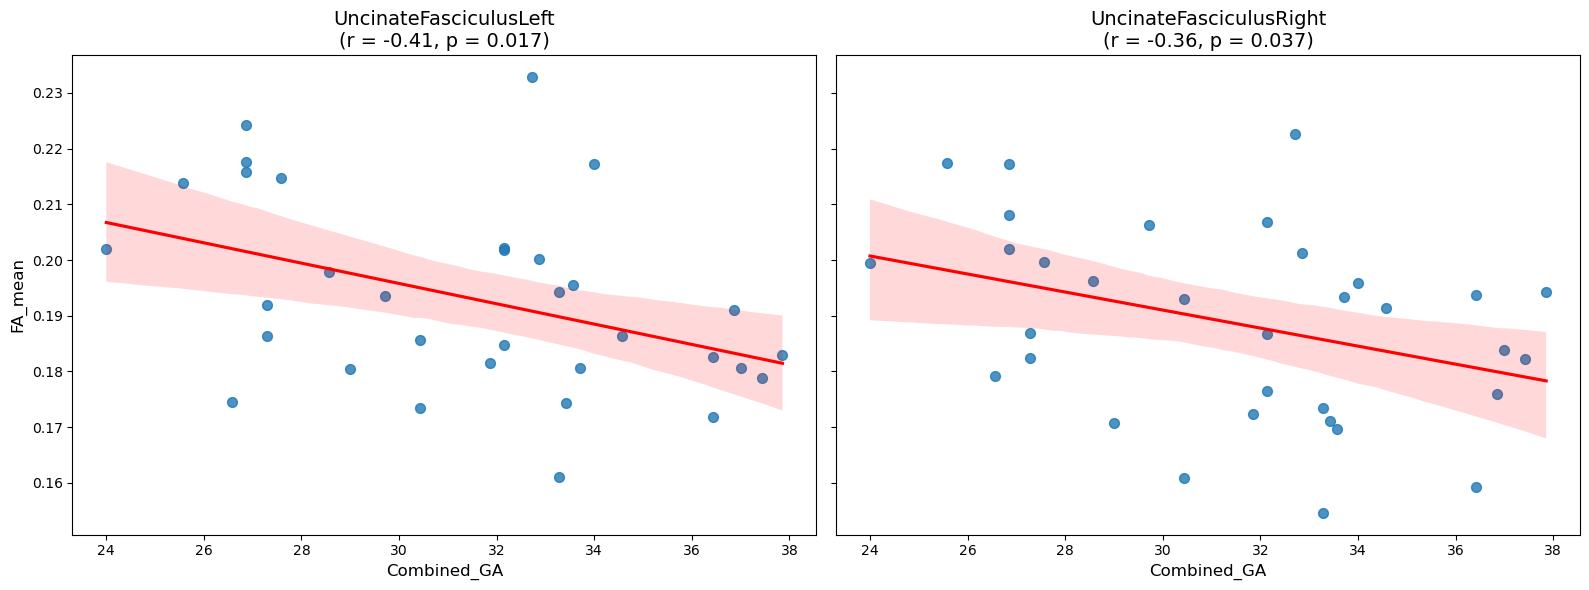

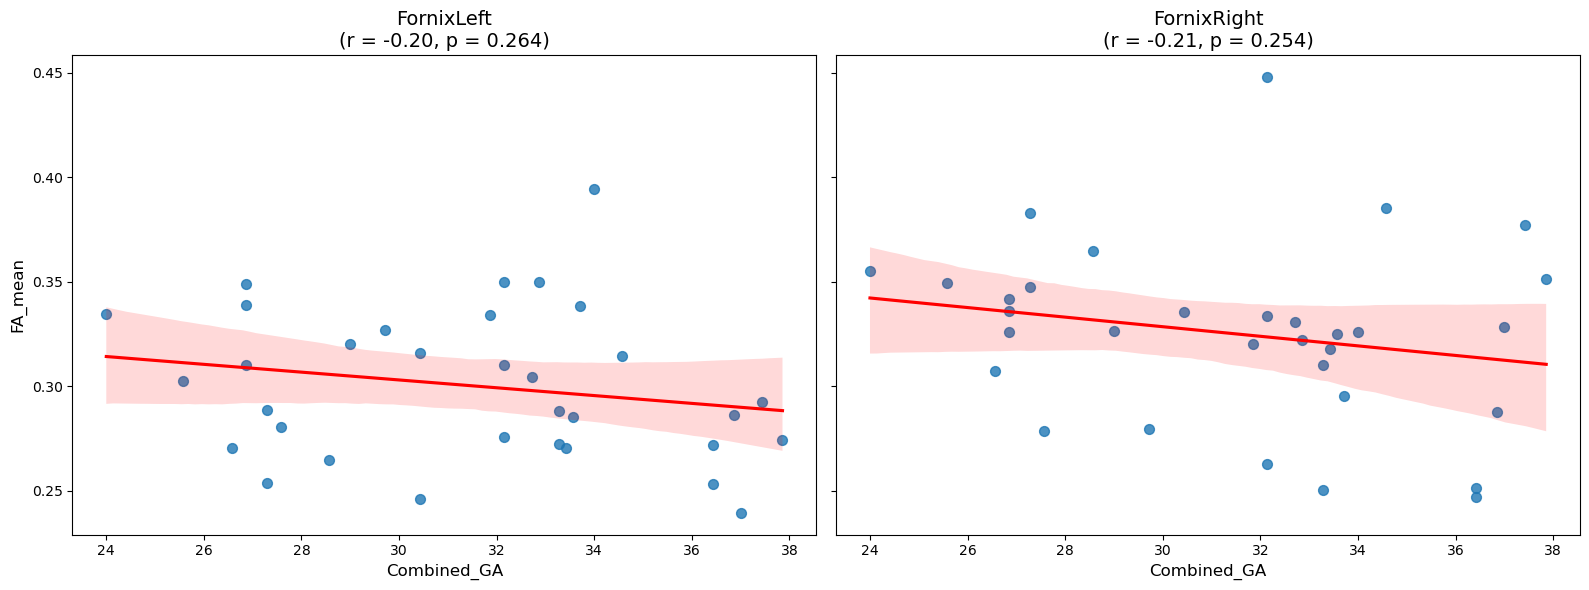

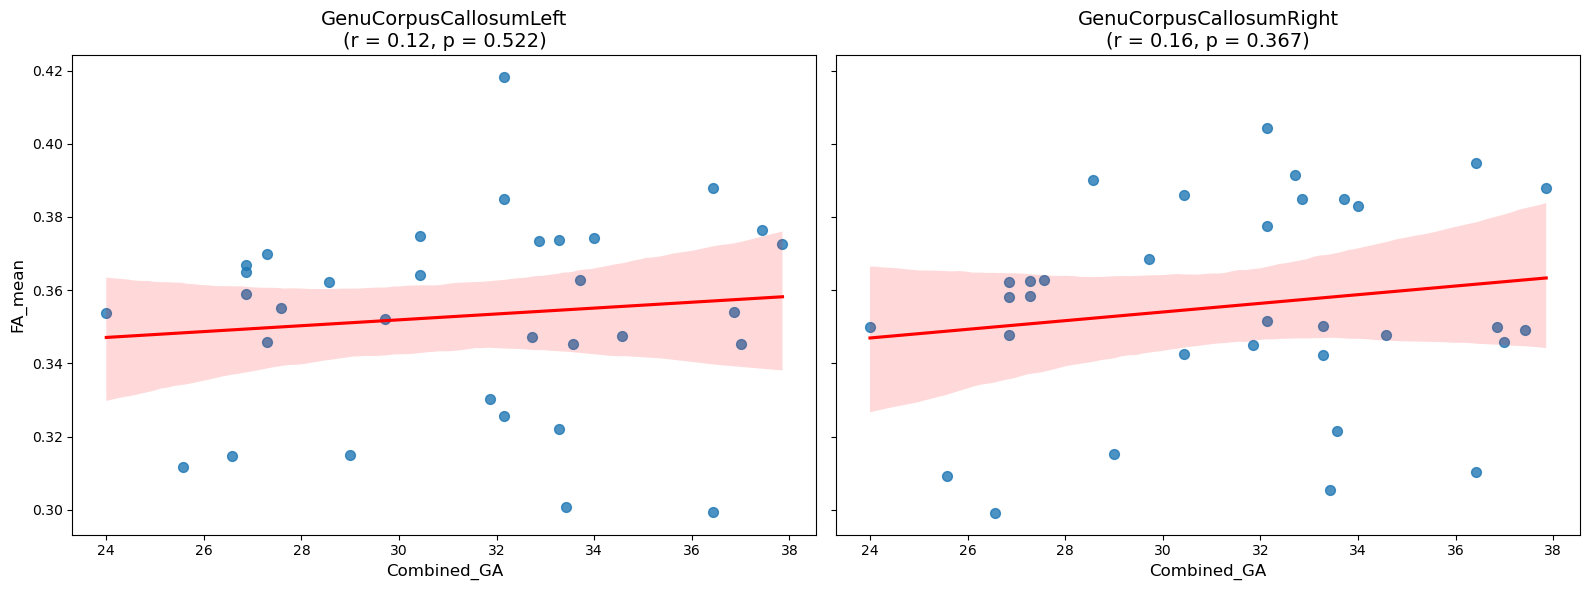

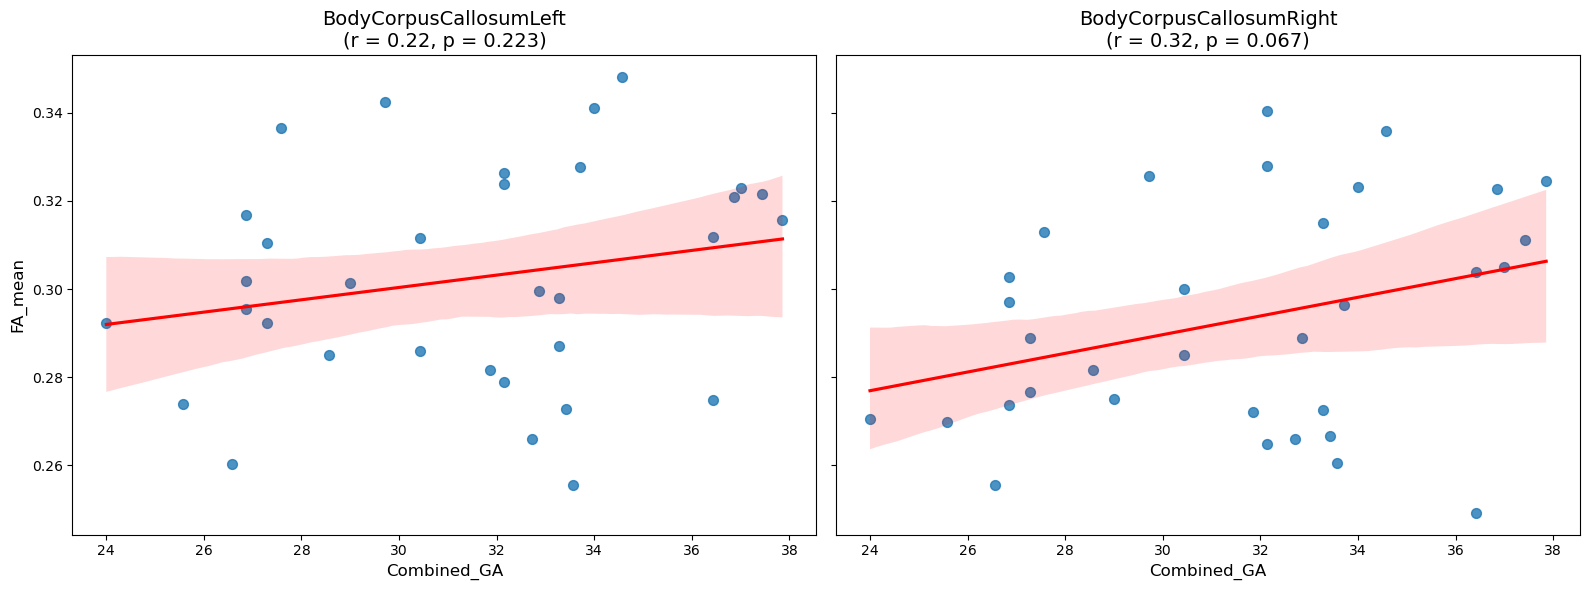

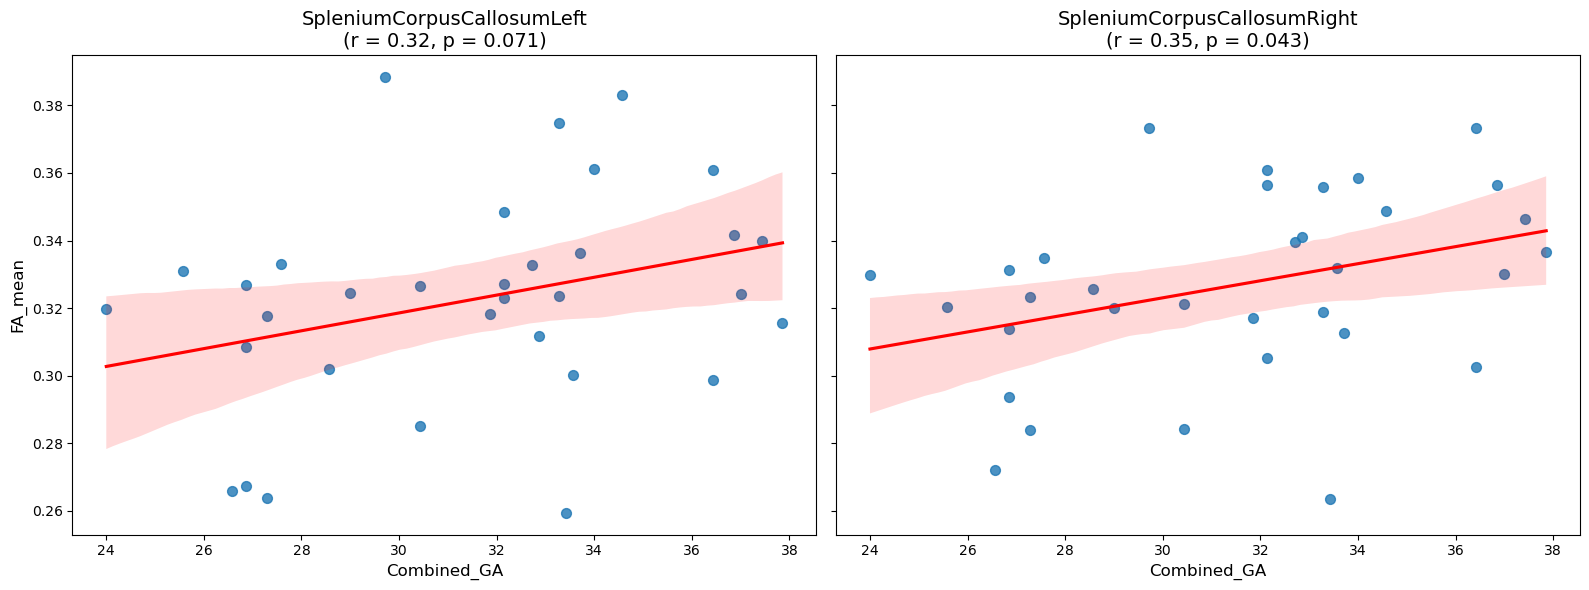

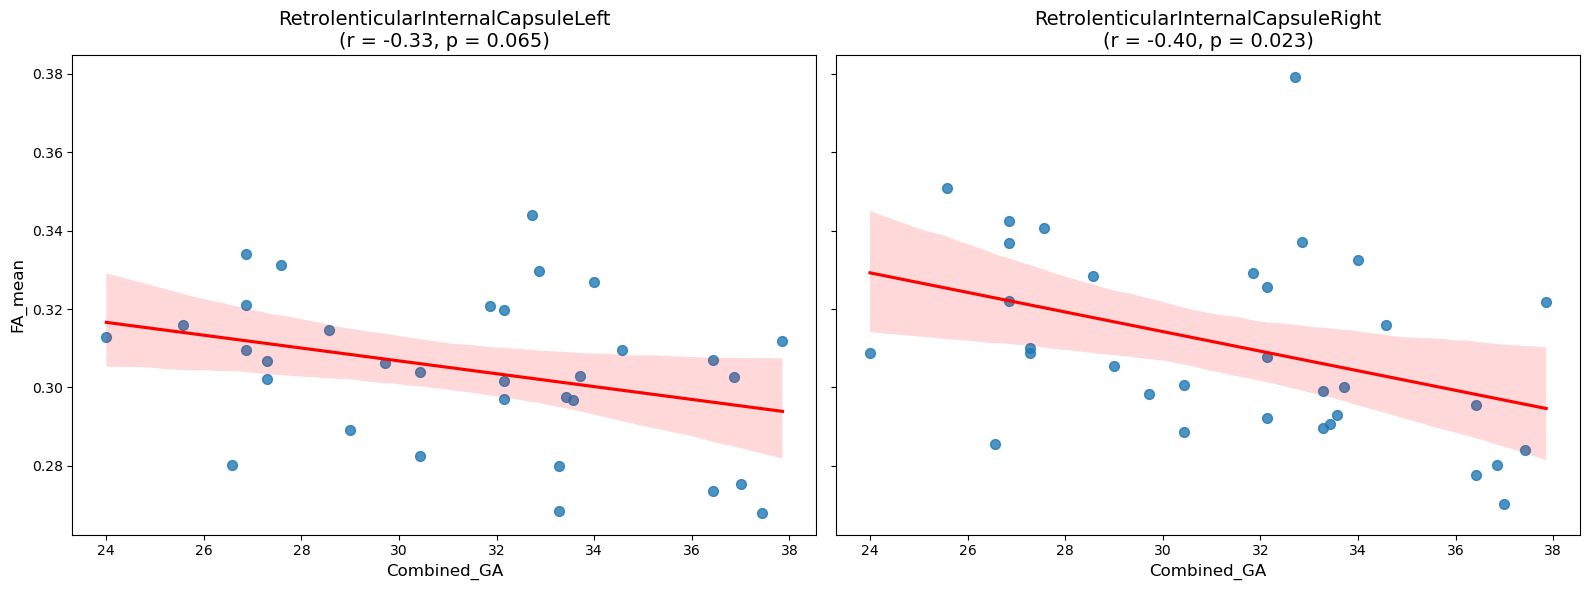

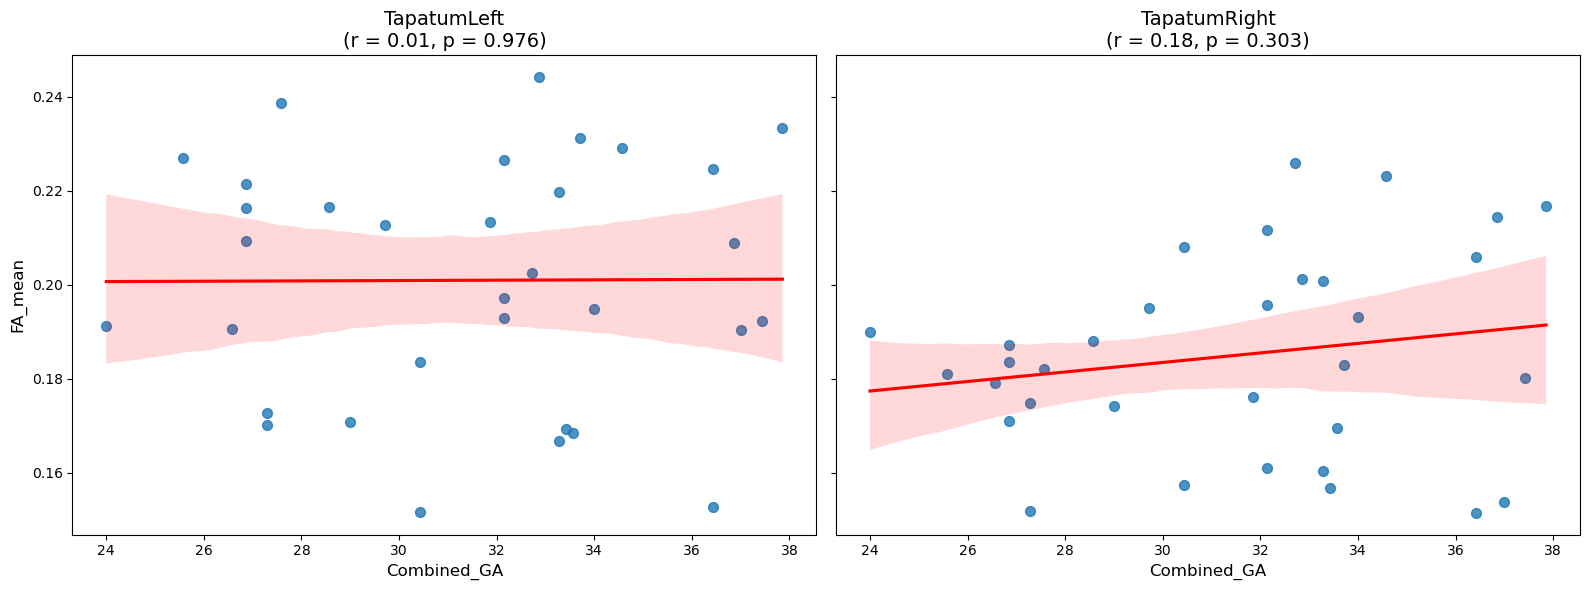

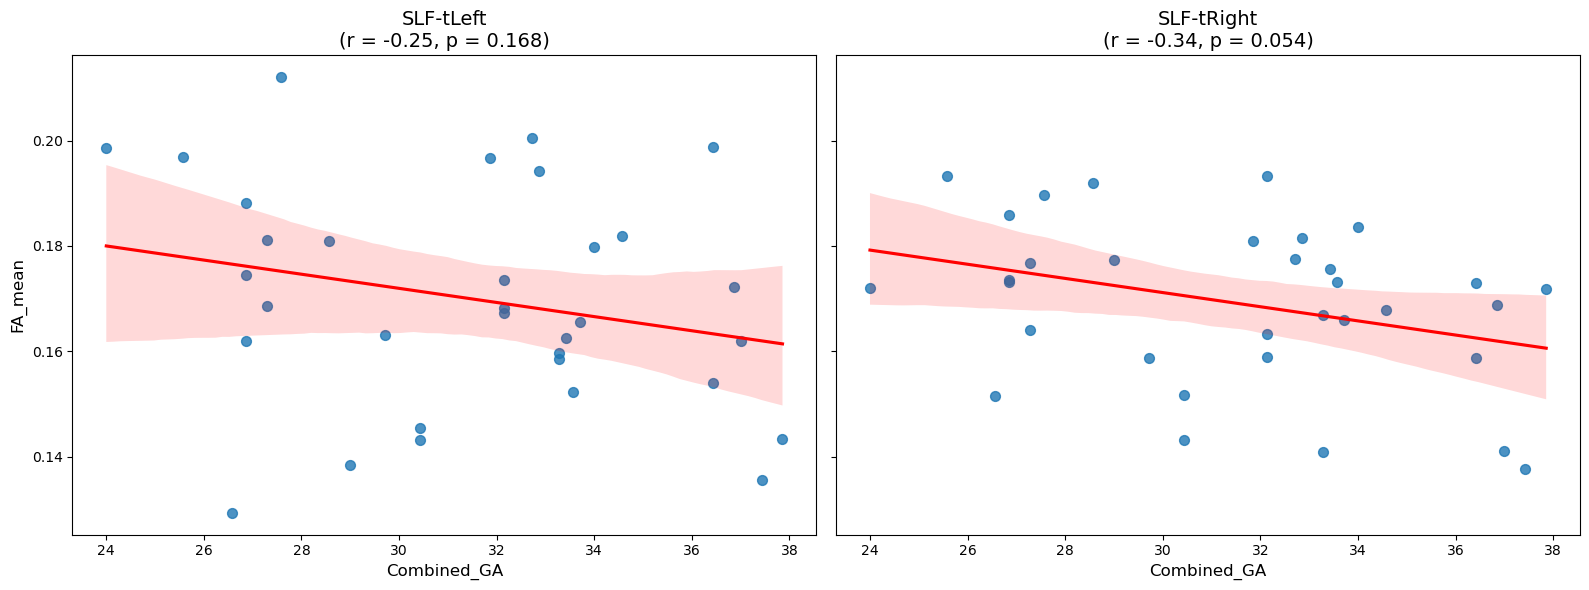

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# User-defined variables
variable_to_plot_x = "Combined_GA"  # Replace with the desired x-axis variable
variable_to_plot_y = "FA_mean"      # Replace with the desired y-axis variable

# Filter df_lut to get all ROIs where Level 2 is "HemisphereWMRight"
rois_to_plot = df_lut[df_lut['Level 2'] == 'HemisphereWMRight']['Level 5'].unique()
#rois_to_plot = df_lut[df_lut['Level 2'] == 'CerebralCortex_R']['Level 5'].unique()


# Loop over each ROI and create subplots for Left and Right
for roi in rois_to_plot:
    # Derive the corresponding Left and Right ROI names
    roi_left = roi.replace("Right", "Left")
    #roi_left = roi.replace("_R", "_L")
    roi_right = roi

    # Filter the DataFrame for the Left ROI
    roi_data_left = df_roi[df_roi['Region'] == roi_left]
    roi_data_left = roi_data_left.merge(df_clinical_demo[['Subject ID', variable_to_plot_x]], on='Subject ID', how='inner')

    # Filter the DataFrame for the Right ROI
    roi_data_right = df_roi[df_roi['Region'] == roi_right]
    roi_data_right = roi_data_right.merge(df_clinical_demo[['Subject ID', variable_to_plot_x]], on='Subject ID', how='inner')

    # Remove rows with NaN or inf values for Left ROI
    roi_data_left = roi_data_left.replace([np.inf, -np.inf], np.nan).dropna(subset=[variable_to_plot_x, variable_to_plot_y])

    # Remove rows with NaN or inf values for Right ROI
    roi_data_right = roi_data_right.replace([np.inf, -np.inf], np.nan).dropna(subset=[variable_to_plot_x, variable_to_plot_y])

    # Check if there is enough data for both ROIs
    if len(roi_data_left) < 2 or len(roi_data_right) < 2:
        print(f"Not enough valid data for ROI pair: {roi_left} and {roi_right}")
        continue

    # Calculate Pearson correlation for Left ROI
    r_left, p_left = pearsonr(roi_data_left[variable_to_plot_x], roi_data_left[variable_to_plot_y])
    p_left_display = f"{p_left:.3f}" if p_left >= 0.001 else "< 0.001"

    # Calculate Pearson correlation for Right ROI
    r_right, p_right = pearsonr(roi_data_right[variable_to_plot_x], roi_data_right[variable_to_plot_y])
    p_right_display = f"{p_right:.3f}" if p_right >= 0.001 else "< 0.001"

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Plot for Left ROI
    sns.regplot(data=roi_data_left, x=variable_to_plot_x, y=variable_to_plot_y, scatter_kws={'s': 50}, line_kws={'color': 'red'}, ax=axes[0])
    axes[0].set_title(f'{roi_left}\n(r = {r_left:.2f}, p = {p_left_display})', fontsize=14)
    axes[0].set_xlabel(variable_to_plot_x, fontsize=12)
    axes[0].set_ylabel(variable_to_plot_y, fontsize=12)

    # Plot for Right ROI
    sns.regplot(data=roi_data_right, x=variable_to_plot_x, y=variable_to_plot_y, scatter_kws={'s': 50}, line_kws={'color': 'red'}, ax=axes[1])
    axes[1].set_title(f'{roi_right}\n(r = {r_right:.2f}, p = {p_right_display})', fontsize=14)
    axes[1].set_xlabel(variable_to_plot_x, fontsize=12)
    axes[1].set_ylabel('')

    # Adjust layout
    plt.tight_layout()
    plt.show()

Plot structures belonging to same identifier in "Level 2"

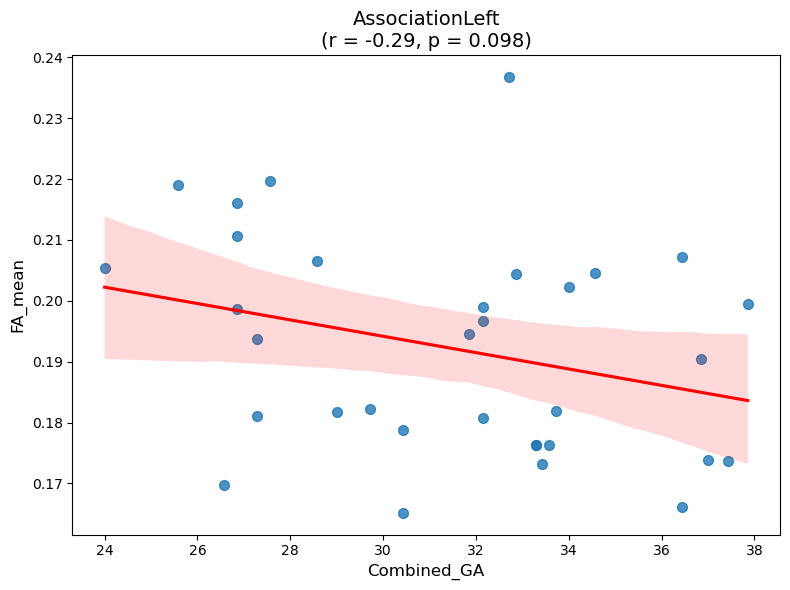

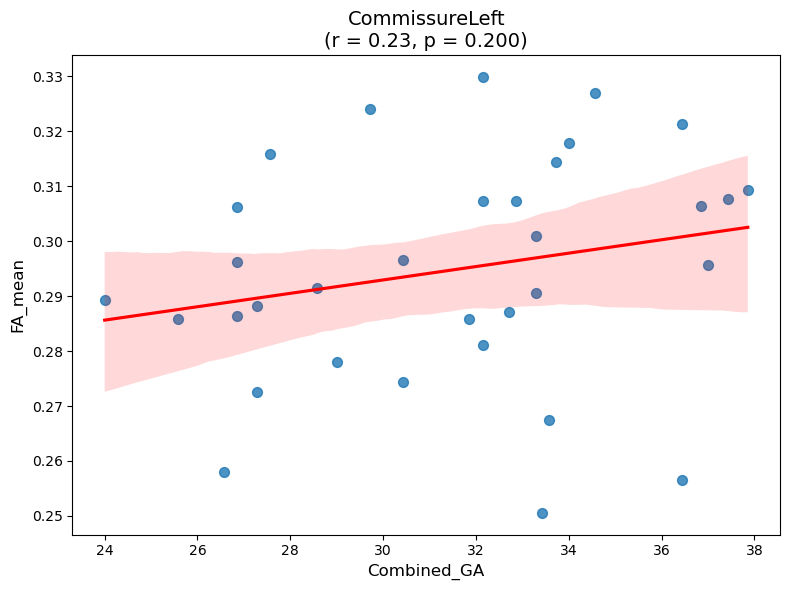

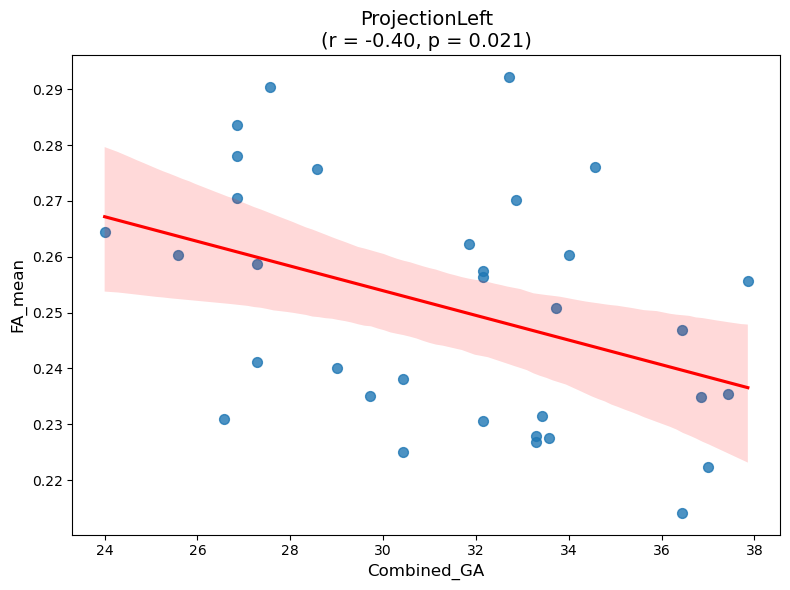

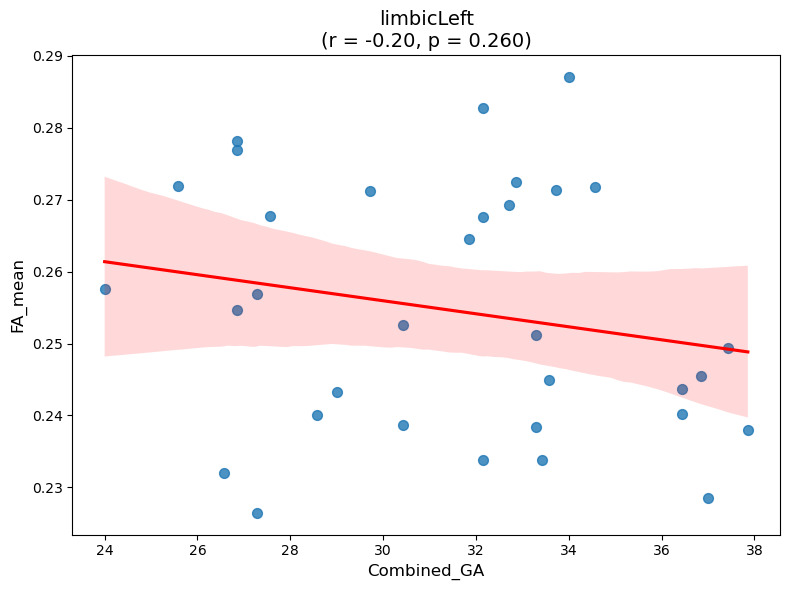

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# User-defined variables
variable_to_plot_x = "Combined_GA"  # Replace with the desired x-axis variable
variable_to_plot_y = "FA_mean"  # Replace with the desired y-axis variable

# Filter df_lut to get all ROIs where Level 2 is "CerebralCortex_R"
#rois_to_plot = df_lut[df_lut['Level 2'] == 'CerebralCortex_R']
rois_to_plot = df_lut[df_lut['Level 2'] == 'HemisphereWMLeft']

# Group by Level 3 and calculate the average of variable_to_plot_x and variable_to_plot_y
grouped_rois = rois_to_plot.groupby('Level 3')

# Loop over each group in Level 3
for level_3, group in grouped_rois:
    # Get the ROIs for the current Level 3 group
    rois = group['Level 5'].unique()

    # Filter the DataFrame for the selected ROIs
    roi_data = df_roi[df_roi['Region'].isin(rois)]

    # Merge variable_to_plot_x from df_clinical_demo
    roi_data = roi_data.merge(df_clinical_demo[['Subject ID', variable_to_plot_x]], on='Subject ID', how='inner')

    # Ensure variable_to_plot_y is in roi_data
    if variable_to_plot_y not in roi_data.columns:
        print(f"'{variable_to_plot_y}' not found in roi_data for Level 3 group: {level_3}")
        continue

    # Remove rows with NaN or inf values
    roi_data = roi_data.replace([np.inf, -np.inf], np.nan).dropna(subset=[variable_to_plot_x, variable_to_plot_y])

    # Check if there is enough data
    if len(roi_data) < 2:
        print(f"Not enough valid data for Level 3 group: {level_3}")
        continue

    # Calculate the average of variable_to_plot_x and variable_to_plot_y for each Subject ID
    averaged_data = roi_data.groupby('Subject ID')[[variable_to_plot_x, variable_to_plot_y]].mean().reset_index()

    # Calculate Pearson correlation
    r, p = pearsonr(averaged_data[variable_to_plot_x], averaged_data[variable_to_plot_y])
    p_display = f"{p:.3f}" if p >= 0.001 else "< 0.001"

    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.regplot(data=averaged_data, x=variable_to_plot_x, y=variable_to_plot_y, scatter_kws={'s': 50}, line_kws={'color': 'red'})

    # Customize the plot
    plt.title(f'{level_3}\n(r = {r:.2f}, p = {p_display})', fontsize=14)
    plt.xlabel(variable_to_plot_x, fontsize=12)
    plt.ylabel(variable_to_plot_y, fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

Introduce covariates into correlation analysis

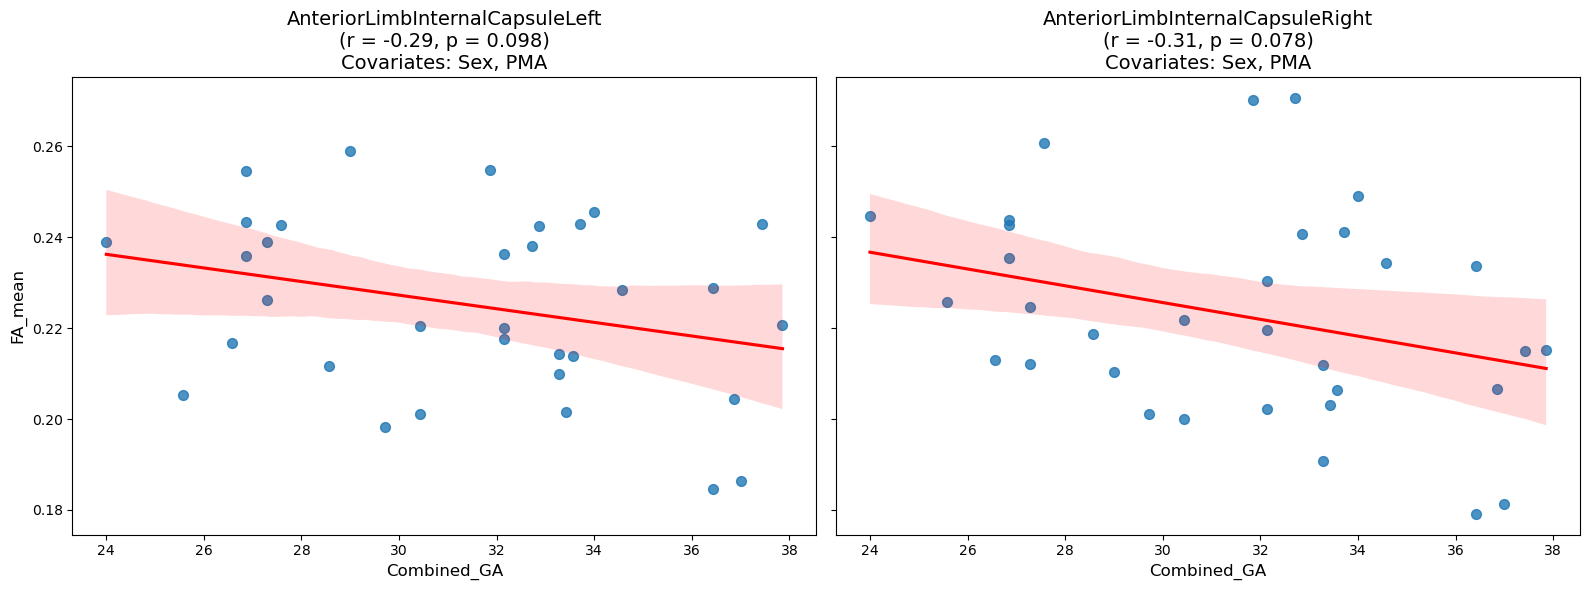

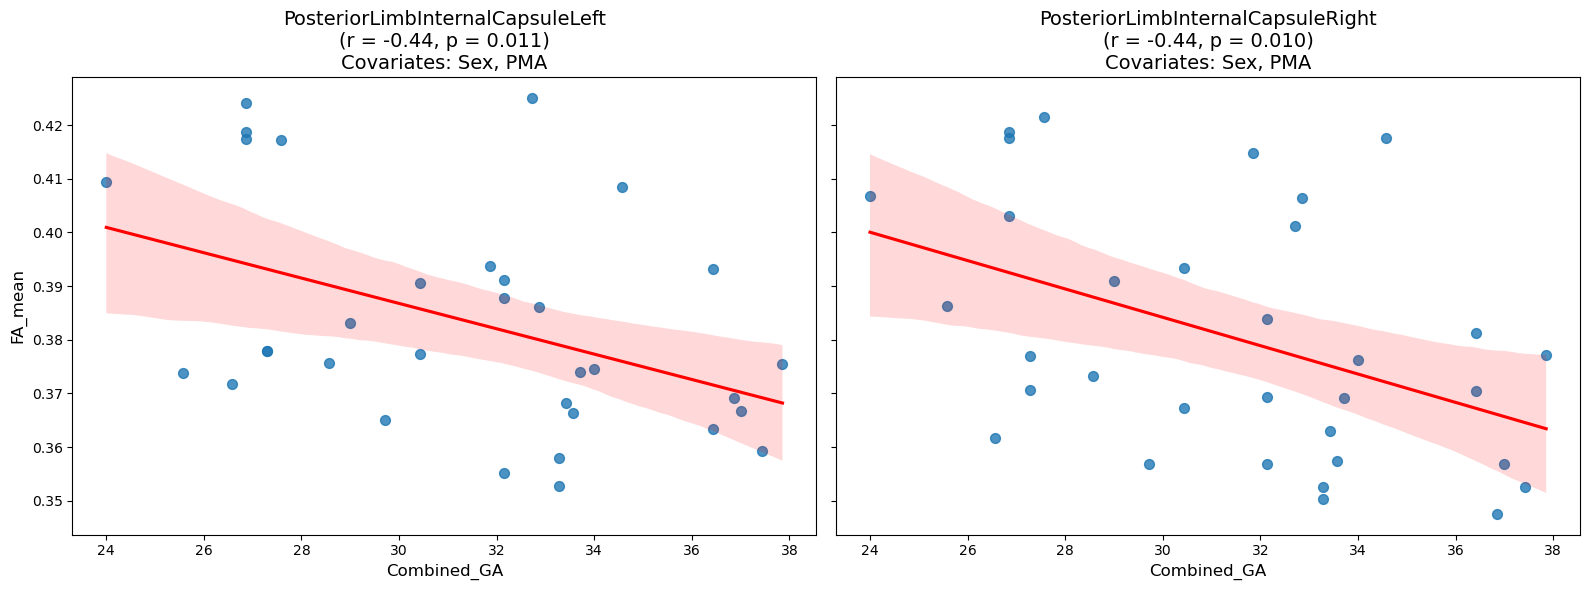

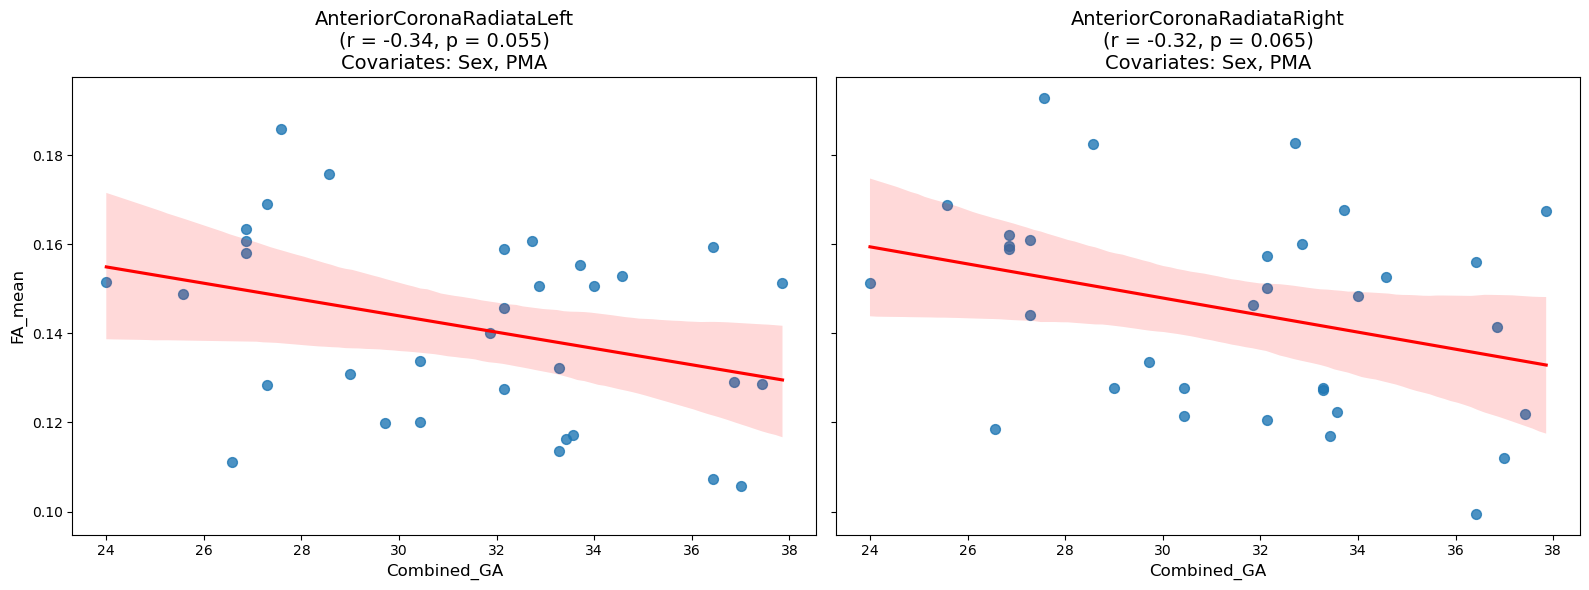

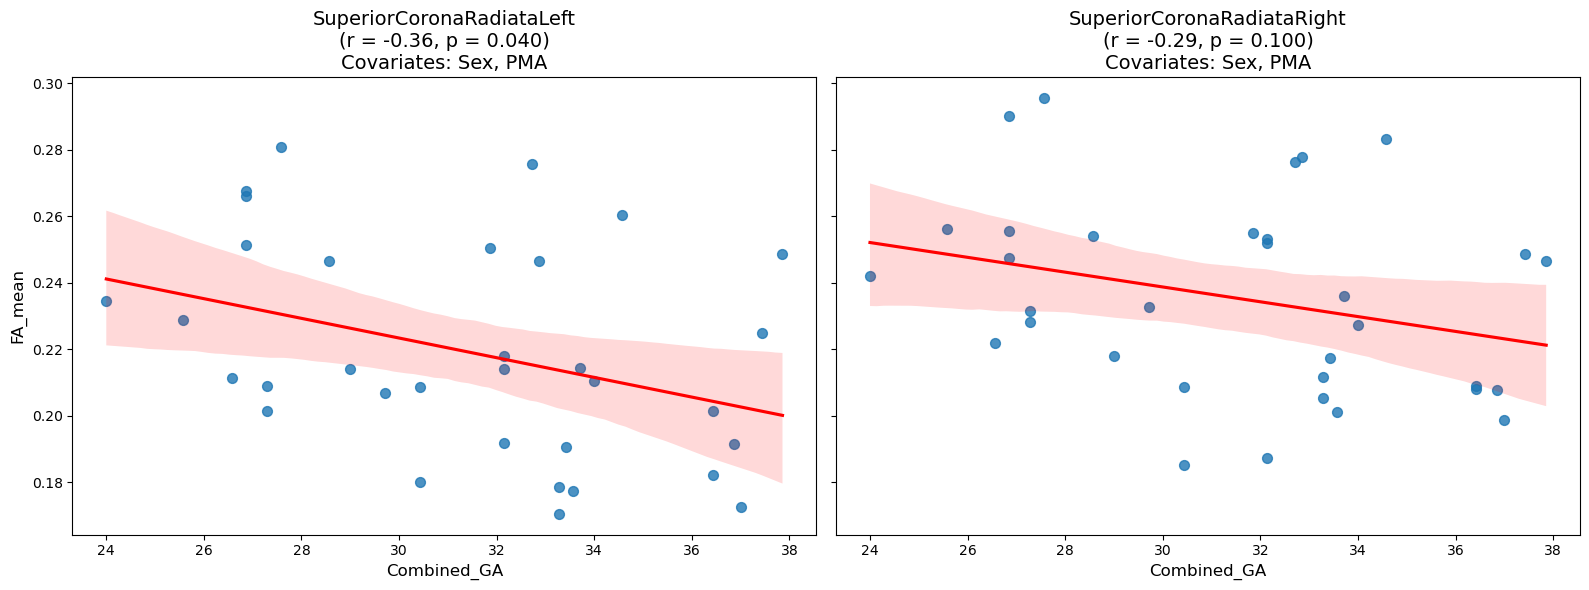

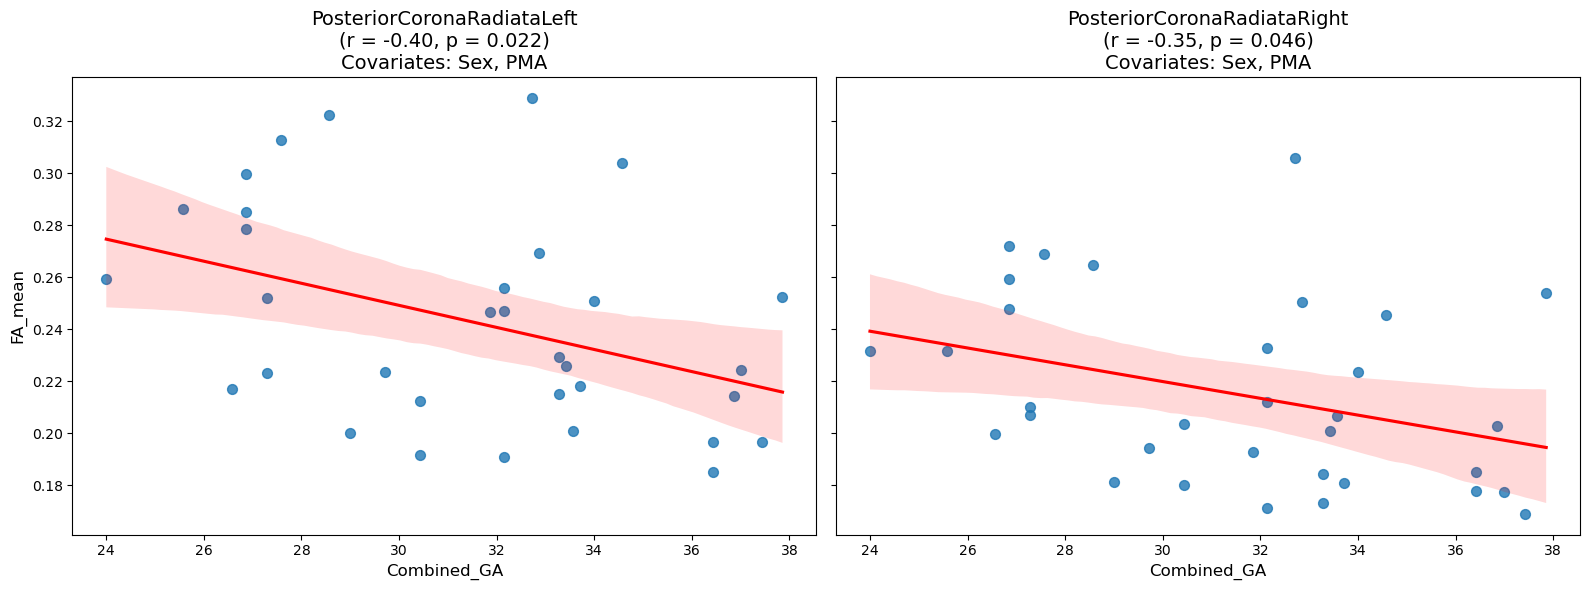

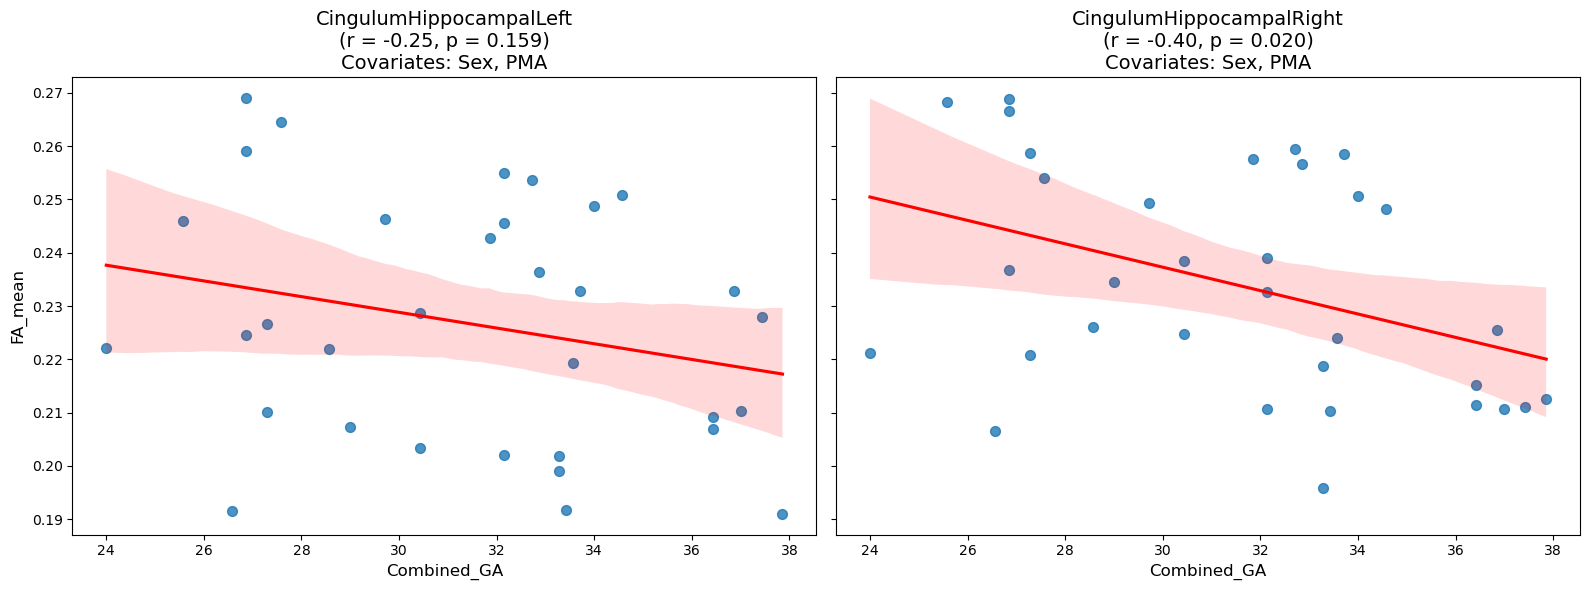

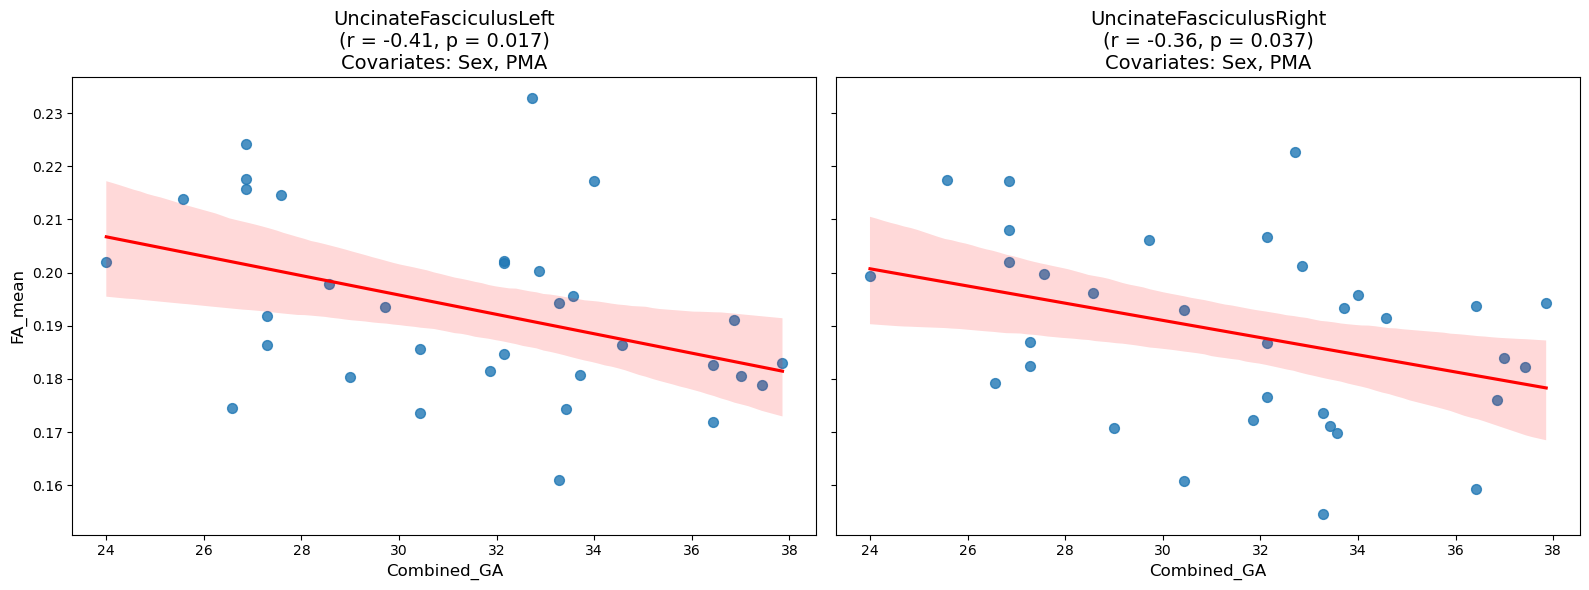

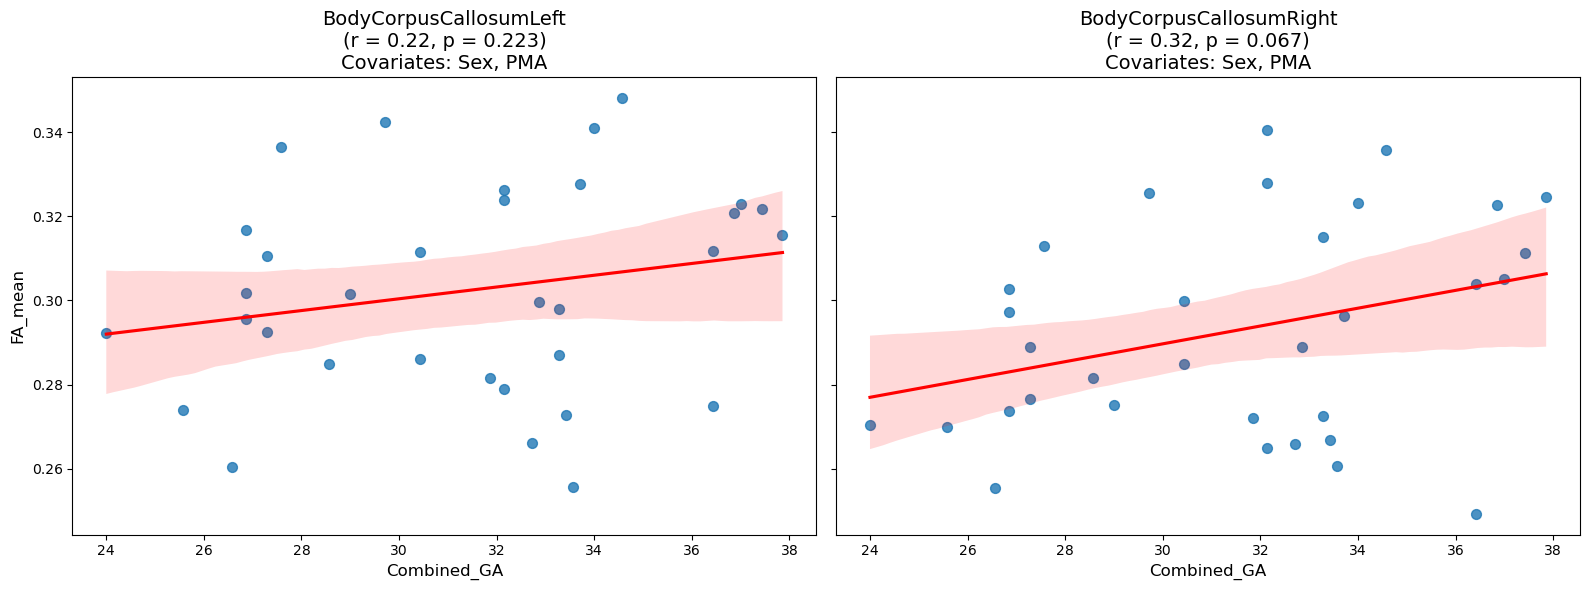

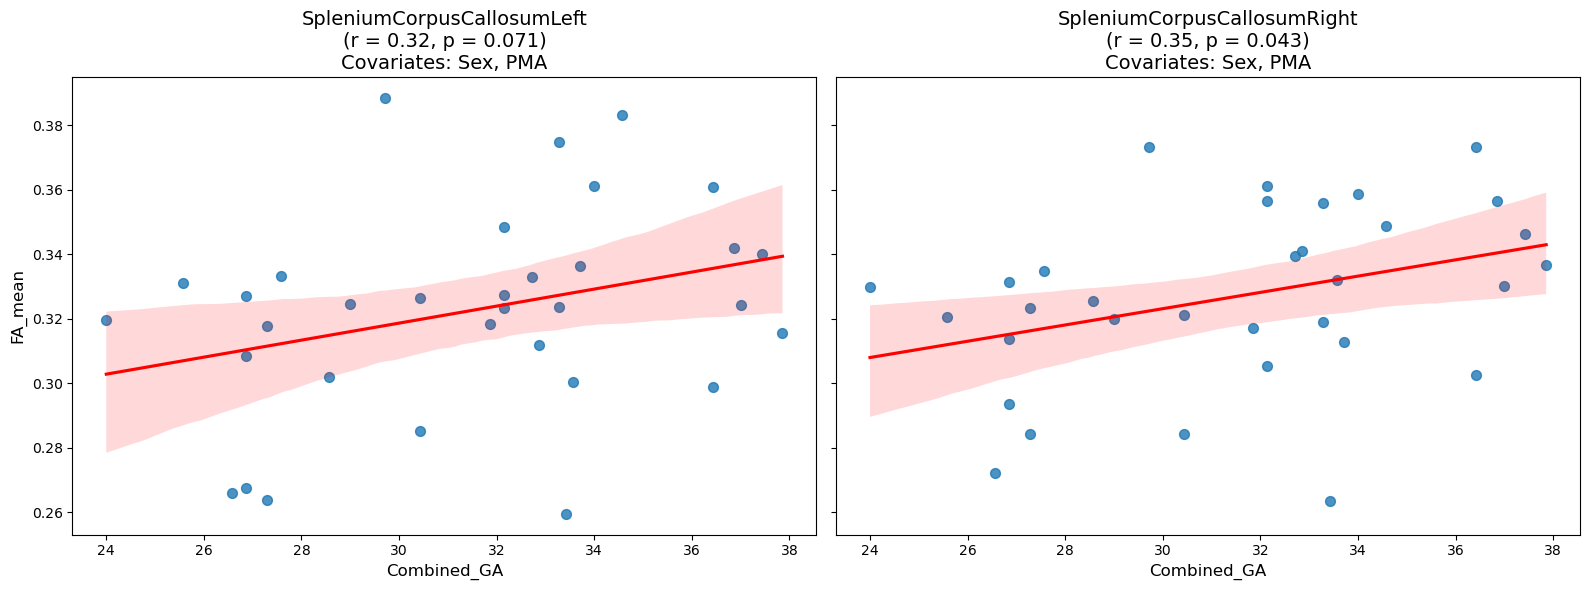

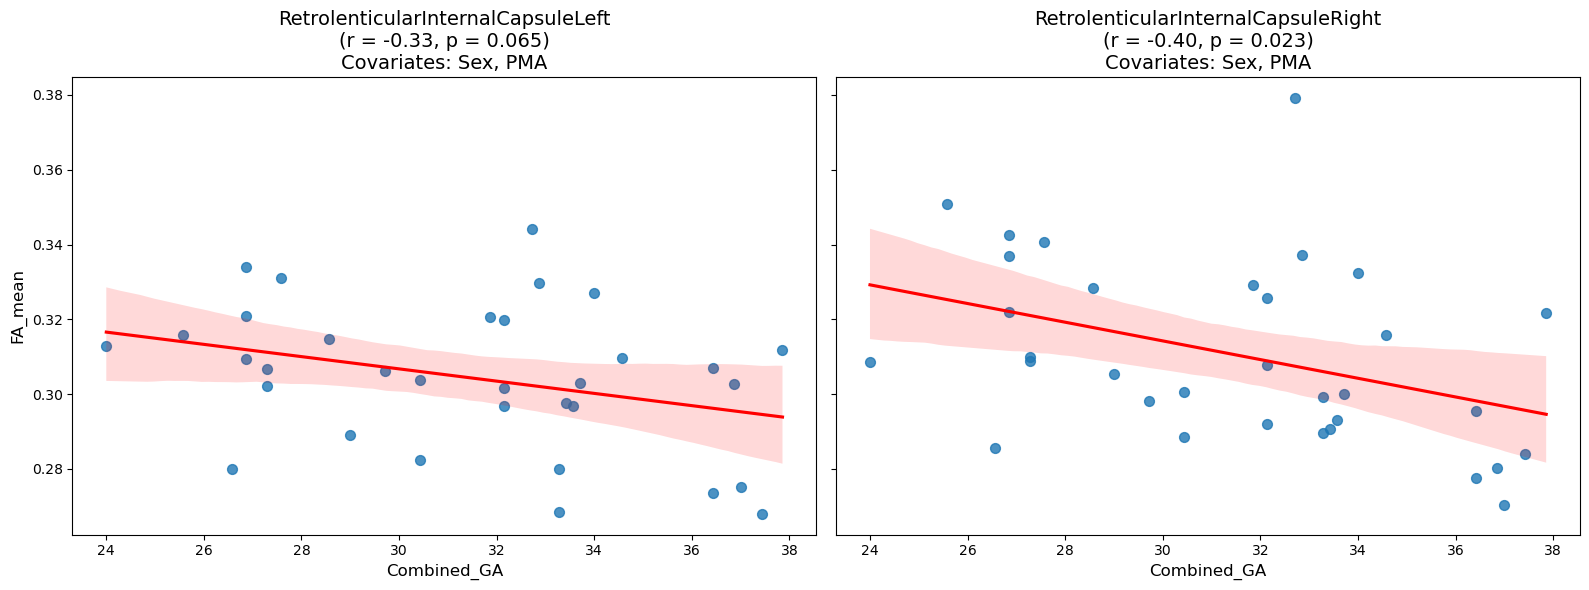

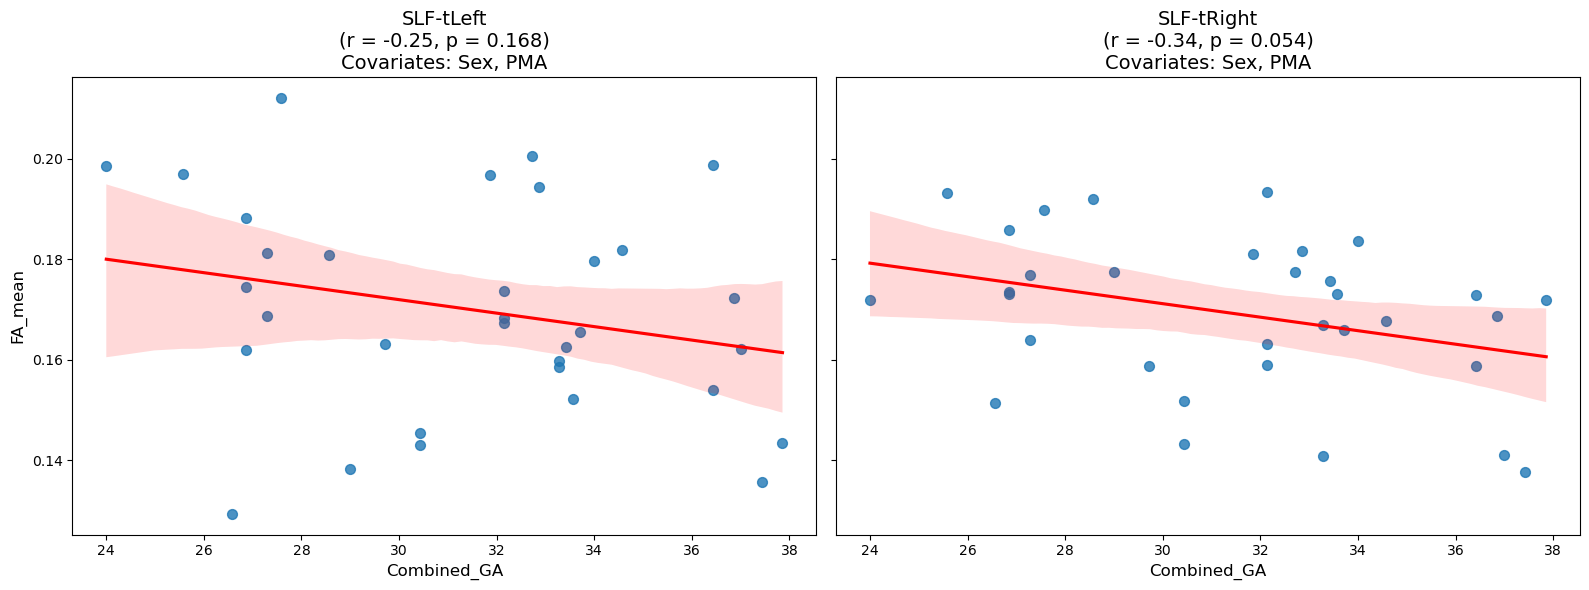

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import statsmodels.api as sm


# User-defined variables
variable_to_plot_x = "PMA"  # Replace with the desired x-axis variable
variable_to_plot_y = "FA_mean"  # Replace with the desired y-axis variable
covariates = ["Sex", "Combined_GA"]  # Covariates to correct for

# Map categorical data in df_clinical_demo before merging
df_clinical_demo['Sex'] = df_clinical_demo['Sex'].map({'M': 0, 'F': 1})  # Map categorical to numeric

# Filter df_lut to get all ROIs where Level 2 is "HemisphereWMRight"
rois_to_plot = df_lut[df_lut['Level 2'] == 'HemisphereWMRight']['Level 5'].unique()

# Loop over each ROI and create subplots for Left and Right
for roi in rois_to_plot:
    # Derive the corresponding Left and Right ROI names
    roi_left = roi.replace("Right", "Left")
    roi_right = roi

    # Filter the DataFrame for the Left ROI
    roi_data_left = df_roi[df_roi['Region'] == roi_left]
    roi_data_left = roi_data_left.merge(df_clinical_demo[['Subject ID', variable_to_plot_x] + covariates], on='Subject ID', how='inner')

    # Filter the DataFrame for the Right ROI
    roi_data_right = df_roi[df_roi['Region'] == roi_right]
    roi_data_right = roi_data_right.merge(df_clinical_demo[['Subject ID', variable_to_plot_x] + covariates], on='Subject ID', how='inner')

    # Remove rows with NaN or inf values for Left ROI
    roi_data_left = roi_data_left.replace([np.inf, -np.inf], np.nan).dropna(subset=[variable_to_plot_x, variable_to_plot_y] + covariates)

    # Remove rows with NaN or inf values for Right ROI
    roi_data_right = roi_data_right.replace([np.inf, -np.inf], np.nan).dropna(subset=[variable_to_plot_x, variable_to_plot_y] + covariates)

    # Check if there is enough data for both ROIs
    if len(roi_data_left) < 2 or len(roi_data_right) < 2:
        print(f"Not enough valid data for ROI pair: {roi_left} and {roi_right}")
        continue

    # Calculate Pearson correlation for Left ROI
    r_left, p_left = pearsonr(roi_data_left[variable_to_plot_x], roi_data_left[variable_to_plot_y])
    p_left_display = f"{p_left:.3f}" if p_left >= 0.001 else "< 0.001"

    # Calculate Pearson correlation for Right ROI
    r_right, p_right = pearsonr(roi_data_right[variable_to_plot_x], roi_data_right[variable_to_plot_y])
    p_right_display = f"{p_right:.3f}" if p_right >= 0.001 else "< 0.001"

    # Only plot if either Left or Right ROI has p-value < 0.01
    if p_left < 0.1 or p_right < 0.1:
        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        # Plot for Left ROI
        sns.regplot(data=roi_data_left, x=variable_to_plot_x, y=variable_to_plot_y, scatter_kws={'s': 50}, line_kws={'color': 'red'}, ax=axes[0])
        axes[0].set_title(f'{roi_left}\n(r = {r_left:.2f}, p = {p_left_display})\nCovariates: {", ".join(covariates)}', fontsize=14)
        axes[0].set_xlabel(variable_to_plot_x, fontsize=12)
        axes[0].set_ylabel(variable_to_plot_y, fontsize=12)

        # Plot for Right ROI
        sns.regplot(data=roi_data_right, x=variable_to_plot_x, y=variable_to_plot_y, scatter_kws={'s': 50}, line_kws={'color': 'red'}, ax=axes[1])
        axes[1].set_title(f'{roi_right}\n(r = {r_right:.2f}, p = {p_right_display})\nCovariates: {", ".join(covariates)}', fontsize=14)
        axes[1].set_xlabel(variable_to_plot_x, fontsize=12)
        axes[1].set_ylabel('')

        # Adjust layout
        plt.tight_layout()
        plt.show()